## Interprétation initiale des fichiers

Dans cette première phase, on a chargé l'ensemble des jeux de données en détectant automatiquement leur encodage afin d'éviter les erreurs de lecture liées aux caractères spéciaux. Chaque fichier a été converti en DataFrame avec le bon séparateur, puis on a extrait des informations clés : dimensions des jeux de données, noms de colonnes, types de variables et nombre de valeurs manquantes.

Ce diagnostic permet de mieux comprendre la structure des données avant tout nettoyage ou transformation, et d'anticiper les étapes de traitement à appliquer (gestion des valeurs nulles, types à corriger, etc.).


In [333]:
import chardet
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
import plotly.figure_factory as ff
import plotly.subplots as sp


# Dictionnaire de fichiers

files = {
    "retours": "dataset/retours V2.csv",
    "achats": "dataset/achats V2.csv",
    "fournisseurs": "dataset/fournisseurs V2.csv",
    "stocks": "dataset/stocks V2.csv",
    "expeditions": "dataset/expeditions V2.csv",
    "commandes": "dataset/commandes V2.csv",
    "produits": "dataset/produits V2.csv"
}

dfs_cleaned = {}

for name, path in files.items():
    # Détection de l'encodage pour chaque fichier
    with open(path, 'rb') as f:
        result = chardet.detect(f.read())
    encoding = result['encoding']
    print(f"Encodage détecté pour {name} : {encoding}")

    # Lecture du fichier avec l'encodage détecté
    dfs_cleaned[name] = pd.read_csv(path, encoding=encoding, sep=';')


# Aperçu des colonnes, types, valeurs manquantes, etc.
info_dict = {}
for name, df in dfs_cleaned.items():
    info_dict[name] = {
        "shape": df.shape,
        "columns": df.columns.tolist(),
        "dtypes": df.dtypes.astype(str).to_dict(),
        "missing_values": df.isnull().sum().to_dict()
    }

info_dict


Encodage détecté pour retours : UTF-8-SIG
Encodage détecté pour achats : UTF-8-SIG
Encodage détecté pour fournisseurs : UTF-8-SIG
Encodage détecté pour stocks : UTF-8-SIG
Encodage détecté pour expeditions : UTF-8-SIG
Encodage détecté pour commandes : UTF-8-SIG
Encodage détecté pour produits : UTF-8-SIG


{'retours': {'shape': (2987, 4),
  'columns': ['id_commande', 'id_produit', 'date_retour', 'motif'],
  'dtypes': {'id_commande': 'object',
   'id_produit': 'object',
   'date_retour': 'object',
   'motif': 'object'},
  'missing_values': {'id_commande': 0,
   'id_produit': 0,
   'date_retour': 0,
   'motif': 0}},
 'achats': {'shape': (10000, 7),
  'columns': ['id_achat',
   'date_achat',
   'id_produit',
   'quantite',
   'id_fournisseur',
   'prix_unitaire',
   'delai_livraison_jours'],
  'dtypes': {'id_achat': 'object',
   'date_achat': 'object',
   'id_produit': 'object',
   'quantite': 'int64',
   'id_fournisseur': 'object',
   'prix_unitaire': 'float64',
   'delai_livraison_jours': 'int64'},
  'missing_values': {'id_achat': 0,
   'date_achat': 0,
   'id_produit': 0,
   'quantite': 0,
   'id_fournisseur': 0,
   'prix_unitaire': 0,
   'delai_livraison_jours': 0}},
 'fournisseurs': {'shape': (50, 6),
  'columns': ['id_fournisseur',
   'nom_fournisseur',
   'ville',
   'pays',
   'fiab

## Normalisation des noms de colonnes et traitement des dates

Dans cette section, une première harmonisation des noms de colonnes a été réalisée : la colonne "entrepôt", présente dans certains fichiers, a été renommée en "entrepot" pour éviter tout problème lié aux accents, notamment lors des jointures ou des traitements ultérieurs.

Ensuite, une fonction générique a été appliquée à l’ensemble des DataFrames pour convertir automatiquement toutes les colonnes contenant le mot "date" en format datetime. Cette étape est essentielle pour permettre des analyses temporelles fiables et précises, en assurant une cohérence des formats sur tous les jeux de données.


In [334]:
# Correction "entrepôt" → "entrepot"
for df in dfs_cleaned.values(): # Use dfs_cleaned instead of normalized_dfs
    if "entrepôt" in df.columns:
        df.rename(columns={"entrepôt": "entrepot"}, inplace=True)

In [335]:
# Conversion des dates
def convert_dates(df):
    for col in df.columns:
        if "date" in col:
            df[col] = pd.to_datetime(df[col], errors="coerce", dayfirst=True)
    return df

# Apply convert_dates to dfs_cleaned and store the result in normalized_dfs
normalized_dfs = {name: convert_dates(df) for name, df in dfs_cleaned.items()}

C:\Users\Franck\AppData\Local\Temp\ipykernel_9060\2023025455.py:5: UserWarning:

Parsing dates in %Y-%m-%d format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.



## Exploration descriptive des jeux de données

À l'aide du package `summarytools`, nous avons généré des résumés statistiques détaillés pour chacun des jeux de données. Cette étape permet de visualiser rapidement :

- la structure des données (types de colonnes, nombre de lignes, etc.)
- la distribution des variables quantitatives et qualitatives
- les fréquences des modalités
- la présence éventuelle de valeurs extrêmes ou incohérentes

Cette analyse exploratoire est cruciale pour identifier les problèmes potentiels dans les données avant de passer au nettoyage approfondi, aux fusions ou à la modélisation.


In [336]:
import summarytools as st
st.dfSummary(dfs_cleaned['retours'])

No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,id_commande[object],1. O0358672. O0062543. O0134364. O0042585. O0489356. O0287147. O0270248. O0270949. O02185610. O03606511. other,"2 (0.1%)2 (0.1%)2 (0.1%)2 (0.1%)2 (0.1%)2 (0.1%)2 (0.1%)2 (0.1%)2 (0.1%)2 (0.1%)2,967 (99.3%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAD+CAYAAAAtWHdlAAAAOnRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjEwLjAsIGh0dHBzOi8vbWF0cGxvdGxpYi5vcmcvlHJYcgAAAAlwSFlzAAAPYQAAD2EBqD+naQAAAzhJREFUeJzt3LFtIlEYRtH3LOTFCcgaiRJ2e6AIp+6YItyEBYG9S8KKwC1cJDgnczQTXPmXpfk8L5fLgMJT8hQQGyWxkREbGbGRERsZsZERGxmxkREbmac5558557p7JI/8m+33GOPXrV+E++eMkhEbGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRERtpbB9jjH/dI3lU038xouKMkhEbGesqMtZVZJxRMmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyBi9kDF7IOKNkxEbG4IWMwQsZZ5SM2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzBCxmDFzLOKBmxkREbGesqMtZVZJxRMmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYy1lVkrKvIOKNkxEbG4IWMwQsZZ5SM2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzBCxmDFzLOKBmxkTF4IWPwQsYZJSM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYy1lVkrKvIOKNkxEbGuoqMdRUZZ5SM2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzBCxmDFzLOKBmxkTF4IWPwQsYZJSM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjY/BCxuCFjDNKRmxkxEbGuoqMdRUZZ5SM2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYx1FRnrKjLOKBmxkTF4IWPwQsYZJSM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjY/BCxuCFjDNKZo4xXsYYz90jeVDn1bIsb5vN5vXWb8J9O51On6traPv9/nu73f699Qtxn47H4/pwOLyurj9cQ9vtdl+3finu2os/EMiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2Misfj4B6R7Jo/npay7L8u7jSYqPJ30WTuVsXUXGHwhkxEZGbGTERkZsZMRGRmxkxEZGbIzKf0WpV2xeyLPPAAAAAElFTkSuQmCC"">",0(0.0%)
2,id_produit[object],1. P003792. P009213. P003574. P005165. P004036. P006207. P000118. P007679. P0097110. P0095211. other,"30 (1.0%)29 (1.0%)29 (1.0%)27 (0.9%)27 (0.9%)27 (0.9%)26 (0.9%)25 (0.8%)24 (0.8%)24 (0.8%)2,719 (91.0%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAD+CAYAAAAtWHdlAAAAOnRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjEwLjAsIGh0dHBzOi8vbWF0cGxvdGxpYi5vcmcvlHJYcgAAAAlwSFlzAAAPYQAAD2EBqD+naQAAA59JREFUeJzt3EFOU1EAhtHbplE7gRASlsECuggX6yJYAPsghg6sMqm5pcapxfQz0nMG4ETK4Mt77cv9Wez3+wGFZfIqIDZKYiMjNjJiIyM2MmIjIzYyYiOzGGOsxxgfxhgv+/1+1700l2Z1e3v7+erq6ma73X5dLBZfBMe5LGdo9/f3Y34/XuHgfO/Z1uv1j/P8ePjNBwQyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyYqONbbfbfexekku1nCd0Hx8fx/w+j4b/61+I98sGgczCn8yi4spGxrqKjHUVGesqMh7qkhEbGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxkTF4IWPwQsaxcDIGL2Rc2cgYvJAxeCFj8ELGQ10yYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyBi9kDF7IOBZOxuCFjA8I5LfR4RZKsq6a/7CsIllXWVZR8J6NjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI3M6riqmiyrOCvHwslYV5FxZSNj8ELG4IWMRx9kxEZGbGTERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGQMXsg4Fk7G4IWMKxsZgxcyBi9kPPogIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjLWVWRsEMhYV5FxZSNjXUXGuoqMRx9kxEZGbGTERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGQMXsg4Fk7G4IWMKxsZgxcyBi9kPPogIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyYiNj8ELGsXAyBi9kvGcj4zZKxrqKjHUVGe/ZyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIWFeRcSycjHUVGVc2MgYvZAxeyHj0QUZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERkZsZMRGxuCFjGPhZAxeyK9sjoRzipe33AkPg5fjBgH+yHyf/5aB1GqGttlsdtfX199P+Y9cpufn508PDw83T09P8254Wmzzywzt7u7u29l+Q96bw4fKU3nORkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERmb169hI95L8z/6mlcPgZZ5PeuuxES7P9nUkdfJAyrFwsmPhBi9kfEAgIzYyYiMjNjJiIyM2MmIjIzYyYmNUfgJUN0Jw81JfNgAAAABJRU5ErkJggg=="">",0(0.0%)
3,date_retour[datetime64[ns]],Min: 2024-01-02Max: 2025-12-01Duration: 699 days,139 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAABNCAYAAACxBha+AAAAOnRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjEwLjAsIGh0dHBzOi8vbWF0cGxvdGxpYi5vcmcvlHJYcgAAAAlwSFlzAAAPYQAAD2EBqD+naQAAASFJREFUeJzt28ENgkAARUE0tmdNZGuyQGzAi8S84O7M3ejh5RNwuR3HsUHhnnwLiI2S2Mg8toWNMZ5nPrfv++v3v2Z+lo2M2MiIjYzYyIiNa9yNulvjlywbGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxkZniWPjZAwO0LBv/vWyOJvGJZSMjNjJiIyM2MmIjIzbWfKjr4ezcLBsZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxkREba57UXcFY+AVuy0ZGbGTERkZsZMRGRmxkxEbGc7aTvL3/PctGRmxkXEb/xJjgby7LRsaykS2p2CY3LnTX7

In [337]:
st.dfSummary(dfs_cleaned['achats'])

No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,id_achat[object],1. PO0099842. PO0099833. PO0099824. PO0099815. PO0099806. PO0099797. PO0099788. PO0099779. PO00997610. PO00997511. other,"1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%)9,990 (99.9%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAD+CAYAAAAtWHdlAAAAOnRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjEwLjAsIGh0dHBzOi8vbWF0cGxvdGxpYi5vcmcvlHJYcgAAAAlwSFlzAAAPYQAAD2EBqD+naQAAAyZJREFUeJzt3D1qAlEYRuF7RfLTKGHAJSR7cBFps/fswiY/lcEiWzgDzvNU6WaKQz4EX+f1eh1Q2CVPAbFREhsZsZERGxmxkREbGbGRERsZsZHZzTnf5pxP3SPZ8n+21zHG49ovwv1zRsmIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNNLbPMcZv90i2avoVIyrOKBmxkbGuImNdRcYZJSM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjY/BCxuCFjDNKRmxkDF7IGLyQcUbJiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MgYvJAxeCHjjJIRGxmxkbGuImNdRcYZJSM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjY11FxrqKjDNKRmxkDF7IGLyQcUbJiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MgYvJAxeCHjjJIRGxmDFzIGL2ScUTJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjY11FxrqKjDNKRmxkrKvIWFeRcUbJiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MgYvJAxeCHjjJIRGxmDFzIGL2ScUTJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MgYvZAxeyDijZMRGRmxkrKvIWFeRcUbJiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MhYV5GxriLjjJIRGxmDFzIGL2ScUTJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MgYvZAxeyDijZOYY43mM8dA9kq3aL8vyfjgcXtZ+Ee7f/hba+Xz+Ph6PP2u/DPfrcrk87W9/3EI7nU5fa78Q980HBDJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjL7/69/dI9ki26NzWVZPnx5koKvhZOxriLjAwIZsZERGxmxkREbGbGRERsZsZERG6PyB2PnS4LP+4TaAAAAAElFTkSuQmCC"">",0(0.0%)
2,date_achat[datetime64[ns]],Min: 2024-01-01Max: 2024-12-31Duration: 365 days,366 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAABNCAYAAACxBha+AAAAOnRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjEwLjAsIGh0dHBzOi8vbWF0cGxvdGxpYi5vcmcvlHJYcgAAAAlwSFlzAAAPYQAAD2EBqD+naQAAARJJREFUeJzt1t0JgzAYQFFbul5nkszkgOkEfRG8+HPOq8gnySXmNedcoPBOpoDYKImNzKcbxZWMMb573lvXdfv3zMnGOU62I+q+i3ptxg324pDf6FUWZu93Xm3mWZzqzvbkjXjCmrqzkREbGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbS+UHKt4e3/pkLFgAAAAASUVORK5CYII="">",0(0.0%)
3,id_produit[object],1. P004822. P005293. P002304. P006785. P006266. P005877. P002768. P008759. P0002910. P0088111. other,"22 (0.2%)21 (0.2%)20 (0.2%)20 (0.2%)20 (0.2%)20 (0.2%)19 (0.2%)19 (0.2%)19 (0.2%)18 (0.2%)9,802 (98.0%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAD+CAYAAAAtWHdlAAAAOnRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjEwLjAsIGh0dHBzOi8vbWF0cGxvdGxpYi5vcmcvlHJYcgAAAAlwSFlzAAAPYQAAD2EBqD+naQAAA1xJREFUeJzt3EFqU2EYhtH/L0HrJKEEsgTdQxfhYl1EFuEegiQDo06u3IIgjuUJJOeMSic3g4d+Ldy3c1mWAYWn5CkgNkpiIyM2MmIjIzYyYiMjNjJiIyM2Mk9zzk9zzufukTzyT7aPY4z3t/4g3D9nlIzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNhIY/s6xvjZPZJHNf0XIyrOKBmxkbGuImNdRcYZJSM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjY/BCxuCFjDNKRmxkDF7IGLyQcUbJiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MgYvJAxeCHjjJIRGxmxkbGuImNdRcYZJSM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjY11FxrqKjDNKRmxkDF7IGLyQcUbJiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MgYvJAxeCHjjJIRGxmDFzIGL2ScUTJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjY11FxrqKjDNKRmxkrKvIWFeRcUbJiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MgYvJAxeCHjjJIRGxmDFzIGL2ScUTJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MgYvZAxeyDijZMRGRmxkrKvIWFeRcUbJiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MhYV5GxriLjjJIRGxmDFzIGL2ScUTJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MgYvZAxeyDijZOYY48MY4133SB7Mr2VZrusXm/1+/3m73b7c+hNxny6Xy7c555c1uM0a2uvr63W32/249QfjvpzP5+fj8fhyOp3Wy3ndrN9cQzscDt9v/eG4S+uvaW/8gUBGbGTERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZm8+dVkO6RPIp/u9qsL7et7xz9/SoI/C9rX+vbuuvXXgsney3cuoqMPxDIiI2M2MiIjYzYyIiNjNjIiI2M2BiV3wr4biQ78PXLAAAAAElFTkSuQmCC"">",0(0.0%)
4,quantite[int64],1. 502. 253. 1004. 755. 1506

In [338]:
st.dfSummary(dfs_cleaned['fournisseurs'])

No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,id_fournisseur[object],1. S0012. S0023. S0034. S0045. S0056. S0067. S0078. S0089. S00910. S01011. other,1 (2.0%)1 (2.0%)1 (2.0%)1 (2.0%)1 (2.0%)1 (2.0%)1 (2.0%)1 (2.0%)1 (2.0%)1 (2.0%)40 (80.0%),"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAD+CAYAAAAtWHdlAAAAOnRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjEwLjAsIGh0dHBzOi8vbWF0cGxvdGxpYi5vcmcvlHJYcgAAAAlwSFlzAAAPYQAAD2EBqD+naQAAA4NJREFUeJzt3EFq21AARVEpmJJObIrBi/EiutguwrsxRR40xRMVgVPSeXMF1jmQgEcu9CIh8V/GeZ4HKLwk3wJioyQ2MmIjIzYyYiMjNjJiIyM2MuMwDF+HYfjy+Hyf5/mt+3q2ZHc8Hr/v9/tvy4fb7fZzHMcfguMzvCyhnc/nt+XnEd37VQ7+q93y63A4/H58Xm6p8Ck8IJARGxmxkREbGbGRERsZsZERGxmxkREbGbGRERsZsZERG+0Ro2maXruvZKt2y+ncy+Xy96TucjR87X8Uz8kGgczoT2ZRcWUjY11FxrqKjHUVGS91yYiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyBi8kDF4IeNYOBmDFzKubGQMXsgYvJAxeCHjpS4ZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRERsZgxcyBi9kHAsnY/BCxgMCGbdRMtZVZKyryFhXkfGAQEZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERsa6iox1FRnHwslYV5FxZSNj8ELG4IWMwQsZL3XJiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIGLyQMXgh41g4GYMXMq5sZAxeyBi8kDF4IeOlLhmxkREbGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxkbGuImNdRcYGgYx1FRlXNjLWVWSsq8hYV5HxUpeM2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2MwQsZgxcyjoWTMXgh48pGxuCFjMELGYMXMl7qkhEbGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxkTF4IWPwQsaxcDIGL2Q8IJBxGyVjXUXGuoqMdRUZDwhkxEZGbGTERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkrKvIWFeRcSycjHUVGVc2MgYvZAxeyBi8kPFSl4zYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzBCxmDFzKOhZMxeGG1KxvP777W3eufwQvP77biqGn3Pnj5sEPgSU3T9Lo8DF6v1+VO1se2/FpCO51Ov+ovZxWrjZq81CUjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyYiNj8LIh08r/zx8HL/6e7gbcVhw1ORa+Pfe1joUbvJDxgEBGbGTERkZsZMRGRmxkxEZGbGTExlD5A37f0x0zeR1CAAAAAElFTkSuQmCC"">",0(0.0%)
2,nom_fournisseur[object],1. Lecomte et Fils2. Morvan3. Germain et Fils4. Philippe5. Blanc6. Jean7. Carlier8. Gaillard S.A.9. Fischer10. Pelletier11. other,1 (2.0%)1 (2.0%)1 (2.0%)1 (2.0%)1 (2.0%)1 (2.0%)1 (2.0%)1 (2.0%)1 (2.0%)1 (2.0%)40 (80.0%),"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAD+CAYAAAAtWHdlAAAAOnRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjEwLjAsIGh0dHBzOi8vbWF0cGxvdGxpYi5vcmcvlHJYcgAAAAlwSFlzAAAPYQAAD2EBqD+naQAAA4NJREFUeJzt3EFq21AARVEpmJJObIrBi/EiutguwrsxRR40xRMVgVPSeXMF1jmQgEcu9CIh8V/GeZ4HKLwk3wJioyQ2MmIjIzYyYiMjNjJiIyM2MuMwDF+HYfjy+Hyf5/mt+3q2ZHc8Hr/v9/tvy4fb7fZzHMcfguMzvCyhnc/nt+XnEd37VQ7+q93y63A4/H58Xm6p8Ck8IJARGxmxkREbGbGRERsZsZERGxmxkREbGbGRERsZsZERG+0Ro2maXruvZKt2y+ncy+Xy96TucjR87X8Uz8kGgczoT2ZRcWUjY11FxrqKjHUVGS91yYiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyBi8kDF4IeNYOBmDFzKubGQMXsgYvJAxeCHjpS4ZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRERsZgxcyBi9kHAsnY/BCxgMCGbdRMtZVZKyryFhXkfGAQEZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERsa6iox1FRnHwslYV5FxZSNj8ELG4IWMwQsZL3XJiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIGLyQMXgh41g4GYMXMq5sZAxeyBi8kDF4IeOlLhmxkREbGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxkbGuImNdRcYGgYx1FRlXNjLWVWSsq8hYV5HxUpeM2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2MwQsZgxcyjoWTMXgh48pGxuCFjMELGYMXMl7qkhEbGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxkTF4IWPwQsaxcDIGL2Q8IJBxGyVjXUXGuoqMdRUZDwhkxEZGbGTERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkrKvIWFeRcSycjHUVGVc2MgYvZAxeyBi8kPFSl4zYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzBCxmDFzKOhZMxeGG1KxvP777W3eufwQvP77biqGn3Pnj5sEPgSU3T9Lo8DF6v1+VO1se2/FpCO51Ov+ovZxWrjZq81CUjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyYiNj8LIh08r/zx8HL/6e7gbcVhw1ORa+Pfe1joUbvJDxgEBGbGTERkZsZMRGRmxkxEZGbGTExlD5A37f0x0zeR1CAAAAAElFTkSuQmCC"">",0(0.0%)
3,ville[object],1. Rome2. Berlin3. Paris4. Dublin5. Zurich6. Copenhague7. Stockholm8. Helsinki9. Amsterdam10. Oslo11. other,6 (12.0%)5 (10.0%)5 (10.0%)4 (8.0%)4 (8.0%)4 (8.0%)4 (8.0%)3 (6.0%)3 (6.0%)3 (6.0%)9 (18.0%),"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAD+CAYAAAAtWHdlAAAAOnRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjEwLjAsIGh0dHBzOi8vbWF0cGxvdGxpYi5vcmcvlHJYcgAAAAlwSFlzAAAPYQAAD2EBqD+naQAAA6FJREFUeJzt3EGKGlEARdEySEgmSiO4GBeRxWYR7kYaHaRDJhVqnIZI+7nYes4gw0oGly9V/JfVPM8TFL4kfwuIjZLYyIiNjNjIiI2M2MiIjYzYyKymafo+TdPXQc/7M8/z26Bn8WDWu93ux2azeRnxsMvl8rparX4Kjvesl9AOh8Pbdrv9

In [339]:
st.dfSummary(dfs_cleaned['stocks'])

No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,date[datetime64[ns]],Min: 2024-01-01Max: 2024-12-31Duration: 365 days,362 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAABNCAYAAACxBha+AAAAOnRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjEwLjAsIGh0dHBzOi8vbWF0cGxvdGxpYi5vcmcvlHJYcgAAAAlwSFlzAAAPYQAAD2EBqD+naQAAARVJREFUeJzt2MENwjAABMGAaI+aLNdEgaEDHggtBs/8o+SxOtm5nOd5QOGavAXERklsZG7Hxuac93efHWM8jh/41hF/5yuWjYzYyIiNjNjIbH1B2MFc6GIhNrJIxfaF3ya7cmYj8xfLZmU2jm2lQynrWGrZLNR/c2ZjjWWzNHySZSMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmLjqDwBvrMe53AHWiAAAAAASUVORK5CYII="">",0(0.0%)
2,id_produit[object],1. P002902. P008243. P000644. P002605. P001546. P003557. P008848. P008389. P0022210. P0016111. other,"3 (0.2%)3 (0.2%)3 (0.2%)3 (0.2%)3 (0.2%)3 (0.2%)3 (0.2%)3 (0.2%)3 (0.2%)3 (0.2%)1,676 (98.2%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAD+CAYAAAAtWHdlAAAAOnRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjEwLjAsIGh0dHBzOi8vbWF0cGxvdGxpYi5vcmcvlHJYcgAAAAlwSFlzAAAPYQAAD2EBqD+naQAAA1xJREFUeJzt3EFqU2EYhtH/L0HrJKEEsgTdQxfhYl1EFuEegiQDo06u3IIgjuUJJOeMSic3g4d+Ldy3c1mWAYWn5CkgNkpiIyM2MmIjIzYyYiMjNjJiIyM2Mk9zzk9zzufukTzyT7aPY4z3t/4g3D9nlIzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNhIY/s6xvjZPZJHNf0XIyrOKBmxkbGuImNdRcYZJSM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjY/BCxuCFjDNKRmxkDF7IGLyQcUbJiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MgYvJAxeCHjjJIRGxmxkbGuImNdRcYZJSM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjY11FxrqKjDNKRmxkDF7IGLyQcUbJiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MgYvJAxeCHjjJIRGxmDFzIGL2ScUTJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjY11FxrqKjDNKRmxkrKvIWFeRcUbJiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MgYvJAxeCHjjJIRGxmDFzIGL2ScUTJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MgYvZAxeyDijZMRGRmxkrKvIWFeRcUbJiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MhYV5GxriLjjJIRGxmDFzIGL2ScUTJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MgYvZAxeyDijZOYY48MY4133SB7Mr2VZrusXm/1+/3m73b7c+hNxny6Xy7c555c1uM0a2uvr63W32/249QfjvpzP5+fj8fhyOp3Wy3ndrN9cQzscDt9v/eG4S+uvaW/8gUBGbGTERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZm8+dVkO6RPIp/u9qsL7et7xz9/SoI/C9rX+vbuuvXXgsney3cuoqMPxDIiI2M2MiIjYzYyIiNjNjIiI2M2BiV3wr4biQ78PXLAAAAAElFTkSuQmCC"">",0(0.0%)
3,entrepot[object],1. Paris2. Lyon3. Marseille,797 (46.7%)576 (33.8%)333 (19.5%),"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAABFCAYAAABdVZTTAAAAOnRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjEwLjAsIGh0dHBzOi8vbWF0cGxvdGxpYi5vcmcvlHJYcgAAAAlwSFlzAAAPYQAAD2EBqD+naQAAAZJJREFUeJzt20FqwkAAheFJCaXdKCJ4GA/Rw/YQ3kaKLmrpJmX2hRYMb+Lk+xZdaio/amTeME1TgYSnyLNAKWUopbyWUp5bX8iCfU/TdGt9ET0Y9/v922az2bW+kKW6Xq8fwzC8C+5+Yw3teDzettvt1wyP15XL5fJyOp125/O5vvOL7U5j/VNDOxwOn/c+WKfq1wxm4AaBGLERIzZixEaM2IgRGzFiI0ZsxIiNGLERIzZixEaM2IgRG9kjRvXcVu4pH4fXZV5jPYlaDwg6t/W7+vrUo+Gtr6MHNgh/s0GYyWDKR0qP72zeiRaqu3WVNdRydbWusoZath7XVe6qF8qPusSIjRixESM2YsRGjNiIERsxYiNGbMSIjRixESM2YsRGjNiI6Wpd1cv/0avu1lXWUMtlg0CMdRUxbhBYxceoj7uVaTblM7lbnyZTPpO7dWo55evipxb+zw0CMWIjRmzEiI0YsREjNmLERozYiBEbMWIjRmzEiI0YsREjNvqe8pncrVOzKZ/J3frYIBBjykdJ+QHWeKNKDc5w4gAAAABJRU5ErkJggg=="">",0(0.0%)
4,niveau_stock[int64],Mean (sd) : 148.6 (88.1)min < med < max:0.0 < 147.5 < 299.0IQR (CV) : 154.0 (1.7),299 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOnRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjEwLjAsIGh0dHBzOi8vbWF0cGxvdGxpYi5vcmcvlHJYcgAAAAlwSFlzAAAPYQAAD2EBqD+naQAAApNJREFUeJzt2r9u2kAAx/G74gQHqBGigs0vUKkDo5e+QR+2a7cM8AK8AQtCQvwRbhDGUDnK1gV8cXw/5/uZc8mF+55zPsVer1cD+O5L3RMAbhEYj1lrn4wxjyWHn67X68s7Twk1CXyOdDgc/oqiaFBm/H6/31hrfxNrMx4s3oZa/MJFpEmSvPT7/eM9A3e7XTidTgfr9br40Ai1AQ+WwPc/v0Wko9Hob4mhxbxrUfdn1sQHS1DlLtlutwdr7R9jzF0TfxNdLpcHI0b5yGLdNtjrevX7/U0VD5agql2yXC6/zmazn3Ecf2u1WneHmmVZmOf59+Px+GyMKfOL10XyyGIdN1jV6xVU9ed3s9k8hWHYmUwmx/F4vLl3YovFYjCfzzvn87llBAkeWR7LbrCPWK/KX6a63W6pBStC

In [340]:
st.dfSummary(dfs_cleaned['expeditions'])

No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,id_expedition[object],1. SHP0424042. SHP0000013. SHP0000024. SHP0000035. SHP0423886. SHP0423877. SHP0423868. SHP0423859. SHP04238410. SHP04238311. other,"1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%)42,394 (100.0%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAD+CAYAAAAtWHdlAAAAOnRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjEwLjAsIGh0dHBzOi8vbWF0cGxvdGxpYi5vcmcvlHJYcgAAAAlwSFlzAAAPYQAAD2EBqD+naQAAAyZJREFUeJzt3D1qAlEYRuF7RfLTKGHAJSR7cBFps/fswiY/lcEiWzgDzvNU6WaKQz4EX+f1eh1Q2CVPAbFREhsZsZERGxmxkREbGbGRERsZsZHZzTnf5pxP3SPZ8n+21zHG49ovwv1zRsmIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNNLbPMcZv90i2avoVIyrOKBmxkbGuImNdRcYZJSM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjY/BCxuCFjDNKRmxkDF7IGLyQcUbJiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MgYvJAxeCHjjJIRGxmxkbGuImNdRcYZJSM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjY11FxrqKjDNKRmxkDF7IGLyQcUbJiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MgYvJAxeCHjjJIRGxmDFzIGL2ScUTJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjY11FxrqKjDNKRmxkrKvIWFeRcUbJiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MgYvJAxeCHjjJIRGxmDFzIGL2ScUTJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MgYvZAxeyDijZMRGRmxkrKvIWFeRcUbJiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MhYV5GxriLjjJIRGxmDFzIGL2ScUTJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MgYvZAxeyDijZOYY43mM8dA9kq3aL8vyfjgcXtZ+Ee7f/hba+Xz+Ph6PP2u/DPfrcrk87W9/3EI7nU5fa78Q980HBDJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjL7/69/dI9ki26NzWVZPnx5koKvhZOxriLjAwIZsZERGxmxkREbGbGRERsZsZERG6PyB2PnS4LP+4TaAAAAAElFTkSuQmCC"">",0(0.0%)
2,id_commande[object],1. O0500002. O0000013. O0000024. O0000045. O0499846. O0499837. O0499828. O0499819. O04997910. O04997811. other,"1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%)42,394 (100.0%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAD+CAYAAAAtWHdlAAAAOnRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjEwLjAsIGh0dHBzOi8vbWF0cGxvdGxpYi5vcmcvlHJYcgAAAAlwSFlzAAAPYQAAD2EBqD+naQAAAyZJREFUeJzt3D1qAlEYRuF7RfLTKGHAJSR7cBFps/fswiY/lcEiWzgDzvNU6WaKQz4EX+f1eh1Q2CVPAbFREhsZsZERGxmxkREbGbGRERsZsZHZzTnf5pxP3SPZ8n+21zHG49ovwv1zRsmIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNNLbPMcZv90i2avoVIyrOKBmxkbGuImNdRcYZJSM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjY/BCxuCFjDNKRmxkDF7IGLyQcUbJiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MgYvJAxeCHjjJIRGxmxkbGuImNdRcYZJSM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjY11FxrqKjDNKRmxkDF7IGLyQcUbJiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MgYvJAxeCHjjJIRGxmDFzIGL2ScUTJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjY11FxrqKjDNKRmxkrKvIWFeRcUbJiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MgYvJAxeCHjjJIRGxmDFzIGL2ScUTJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MgYvZAxeyDijZMRGRmxkrKvIWFeRcUbJiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MhYV5GxriLjjJIRGxmDFzIGL2ScUTJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MgYvZAxeyDijZOYY43mM8dA9kq3aL8vyfjgcXtZ+Ee7f/hba+Xz+Ph6PP2u/DPfrcrk87W9/3EI7nU5fa78Q980HBDJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjL7/69/dI9ki26NzWVZPnx5koKvhZOxriLjAwIZsZERGxmxkREbGbGRERsZsZERG6PyB2PnS4LP+4TaAAAAAElFTkSuQmCC"">",0(0.0%)
3,id_produit[object],1. P006202. P009813. P003704. P001435. P006716. P001827. P007808. P006919. P0054110. P0053211. other,"227 (0.5%)208 (0.5%)206 (0.5%)195 (0.5%)195 (0.5%)194 (0.5%)194 (0.5%)194 (0.5%)193 (0.5%)193 (0.5%)40,405 (95.3%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAD+CAYAAAAtWHdlAAAAOnRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjEwLjAsIGh0dHBzOi8vbWF0cGxvdGxpYi5vcmcvlHJYcgAAAAlwSFlzAAAPYQAAD2EBqD+naQAAA2xJREFUeJzt3EFqE2EAhuGZEkQ3CSWQw+QQHtZD5DZBkoWVbkb+EFe2KrR9C83zgJLduHiZTIb/c16WZYLCXXIVEBslsZERGxmxkREbGbGRERsZsZGZp2n6Mj4sy/LQXZZbtNput1/Hh3mevwmOt3S3Xq/vx59pmj696ZW4eZ7ZyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI3M6nw+f79+fuwuyy2yQSAz+y+zqLizkbGuImNdRcarDzJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MgYvZBwLJ2PwQsadjYzBCxmDFzJefZARGxmxkREbGbGRERsZsZERGx

In [341]:
st.dfSummary(dfs_cleaned['commandes'])

No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,id_commande[object],1. O0500002. O0000013. O0000024. O0000045. O0499846. O0499837. O0499828. O0499819. O04997910. O04997811. other,"1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%)1 (0.0%)42,394 (100.0%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAD+CAYAAAAtWHdlAAAAOnRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjEwLjAsIGh0dHBzOi8vbWF0cGxvdGxpYi5vcmcvlHJYcgAAAAlwSFlzAAAPYQAAD2EBqD+naQAAAyZJREFUeJzt3D1qAlEYRuF7RfLTKGHAJSR7cBFps/fswiY/lcEiWzgDzvNU6WaKQz4EX+f1eh1Q2CVPAbFREhsZsZERGxmxkREbGbGRERsZsZHZzTnf5pxP3SPZ8n+21zHG49ovwv1zRsmIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNNLbPMcZv90i2avoVIyrOKBmxkbGuImNdRcYZJSM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjY/BCxuCFjDNKRmxkDF7IGLyQcUbJiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MgYvJAxeCHjjJIRGxmxkbGuImNdRcYZJSM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjY11FxrqKjDNKRmxkDF7IGLyQcUbJiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MgYvJAxeCHjjJIRGxmDFzIGL2ScUTJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjY11FxrqKjDNKRmxkrKvIWFeRcUbJiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MgYvJAxeCHjjJIRGxmDFzIGL2ScUTJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MgYvZAxeyDijZMRGRmxkrKvIWFeRcUbJiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MhYV5GxriLjjJIRGxmDFzIGL2ScUTJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MgYvZAxeyDijZOYY43mM8dA9kq3aL8vyfjgcXtZ+Ee7f/hba+Xz+Ph6PP2u/DPfrcrk87W9/3EI7nU5fa78Q980HBDJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjL7/69/dI9ki26NzWVZPnx5koKvhZOxriLjAwIZsZERGxmxkREbGbGRERsZsZERG6PyB2PnS4LP+4TaAAAAAElFTkSuQmCC"">",0(0.0%)
2,date_commande[datetime64[ns]],Min: 2024-01-01Max: 2024-12-12Duration: 346 days,144 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAABNCAYAAACxBha+AAAAOnRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjEwLjAsIGh0dHBzOi8vbWF0cGxvdGxpYi5vcmcvlHJYcgAAAAlwSFlzAAAPYQAAD2EBqD+naQAAASJJREFUeJzt2cENgkAQQFE0tmdNZGuyQGxALyR+F3jvagwHfgaYvW3btkDhnlwFxEZJbGQe3aU4kjHGc8//1nV9ffvNZCMjNjJiIyM2MmIjIzauufr4xec28zDZyIiNjNjIiI2M2MiIjTlWH3tXEfCJycY1l7qce+FtspERGxmxkREbGbGRERsZsZGxZzu5MdEpkMlGRmxkPEbjR9M60fFR7RSxHenccEz0DlU7RWx7XfnG/4N3NjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNpbKG49IHueXMlEBAAAAAElFTkSuQmCC"">","26,004(61.3%)"
3,id_produit[object],1. P006202. P009813. P003704. P001435. P006716. P001827. P007808. P006919. P0054110. P0053211. other,"227 (0.5%)208 (0.5%)206 (0.5%)195 (0.5%)195 (0.5%)194 (0.5%)194 (0.5%)194 (0.5%)193 (0.5%)193 (0.5%)40,405 (95.3%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAD+CAYAAAAtWHdlAAAAOnRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjEwLjAsIGh0dHBzOi8vbWF0cGxvdGxpYi5vcmcvlHJYcgAAAAlwSFlzAAAPYQAAD2EBqD+naQAAA2xJREFUeJzt3EFqE2EAhuGZEkQ3CSWQw+QQHtZD5DZBkoWVbkb+EFe2KrR9C83zgJLduHiZTIb/c16WZYLCXXIVEBslsZERGxmxkREbGbGRERsZsZGZp2n6Mj4sy/LQXZZbtNput1/Hh3mevwmOt3S3Xq/vx59pmj696ZW4eZ7ZyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI3M6nw+f79+fuwuyy2yQSAz+y+zqLizkbGuImNdRcarDzJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MgYvZBwLJ2PwQsadjYzBCxmDFzJefZARGxmxkREbGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxkTF4IeNYOBmDFzKe2cj4GiVjXUXGuoqMZzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjLWVWQcCydjXUXGnY2MwQsZgxcyXn2QERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRERsZsZExeCHjWDgZgxcy7mxkDF7IGLyQ8eqDjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MhYV5GxQSBjXUXGnY2MdRUZ6yoyXn2QERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRERsZsZExeCHjWDgZgxcy7mxkDF7IGLyQ8eqDjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2MwQsZx8LJGLyQ8cxGxtcoGesqMtZVZDyzkREbGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRsa4i41g4GesqMu5sZAxeyBi8kPHqg4zYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjMELGcfCyRi8kN/ZHAnntTw+9y15GbxcNwjwYuM3wHPjqdUIbb/fP2w2m58vvxS37HQ6fT4cDvfH43F8U/4Z2/hrhLbb7X68y7+Qj+byg/Mp3rORERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRWf0+GtJdko/qXx1dBi/jDNLfjobA/7oOqJ4cTzkWTnYs3OCFjB8IZMRGRmxkxEZGbGTERkZsZMRGRmxMlV+UdRAnrzdqNQAAAABJRU5ErkJggg

In [342]:
st.dfSummary(dfs_cleaned['produits'])

No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,id_produit[object],1. P010002. P000013. P000024. P000035. P000046. P000057. P000068. P000079. P0098410. P0098311. other,1 (0.1%)1 (0.1%)1 (0.1%)1 (0.1%)1 (0.1%)1 (0.1%)1 (0.1%)1 (0.1%)1 (0.1%)1 (0.1%)990 (99.0%),"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAD+CAYAAAAtWHdlAAAAOnRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjEwLjAsIGh0dHBzOi8vbWF0cGxvdGxpYi5vcmcvlHJYcgAAAAlwSFlzAAAPYQAAD2EBqD+naQAAA1JJREFUeJzt3MFpG1EYRtH3jHCcjYQRqISkBxWRYlOEikgPIkiLOMlmwiwMLiBcgXTO0pvR4uLfgvk8l2UZUHhKngJioyQ2MmIjIzYyYiMjNjJiIyM2MmIj8zTn/DrnfOkeySP/Zvsyxvh06w/C/XNGyYiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI00th9jjD/dI3lU038xouKMkhEbGesqMtZVZJxRMmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyBi9kDF7IOKNkxEbG4IWMwQsZZ5SM2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzBCxmDFzLOKBmxkREbGesqMtZVZJxRMmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYy1lVkrKvIOKNkxEbG4IWMwQsZZ5SM2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzBCxmDFzLOKBmxkTF4IWPwQsYZJSM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYy1lVkrKvIOKNkxEbGuoqMdRUZZ5SM2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzBCxmDFzLOKBmxkTF4IWPwQsYZJSM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjY/BCxuCFjDNKRmxkxEbGuoqMdRUZZ5SM2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYx1FRnrKjLOKBmxkTF4IWPwQsYZJSM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjY/BCxuCFjDNKZo4xPo8xnrtH8oD+Lsvyttnv99+22+3rrT8N9+t6vf6cc37frKEdj8e33W73+9YfivtzuVxeTqfT6/l8ft6sP1hDOxwOv279wbhb659qviDQERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGR2by/BtI9kkfysa3N+mLb+r7R+2sg8L+tja1v63otnOy1cOsqMr4gkBEbGbGRERsZsZERGxmxkREbGbExKv8AwgdpOXa5aM0AAAAASUVORK5CYII="">",0(0.0%)
2,categorie[object],1. Soins de la peau2. Soins capillaires3. Accessoires4. Maquillage5. Parfums,210 (21.0%)206 (20.6%)204 (20.4%)190 (19.0%)190 (19.0%),"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAABzCAYAAACPdnBjAAAAOnRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjEwLjAsIGh0dHBzOi8vbWF0cGxvdGxpYi5vcmcvlHJYcgAAAAlwSFlzAAAPYQAAD2EBqD+naQAAAftJREFUeJzt2zGK21AARVEpmJA0NoPBi/Eistgswrsxg13MDGkUtIjcH/zPKdxKxUVC5r9127YFCt+Sq4DYKImNzLosy89lWb4vY/3Ztu1z8D3wjx3O5/Ov4/H4tgz0fD7f13X9LbjXdthDu16vn6fT6WvEDTwejx+32+3tfr/vT1exvbDD/rOHdrlcPgbex/4q58X5QCAjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyYqM99bEf81kGGXltWof94OJ+nmzkMZ/9HvbTuqOuT8OxcDKr3SgVHwhM9Rr1Cp3E8HWVZdU8hq6rLKvm8j+sqyyrJuEDgYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjTnWVZZVcxm+rrKsmodj4WSsq8j4QCDjNUrGuoqMdRUZ6yoyPhDIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIWFeRsa4i41g4GesqXv7J5mk2oSGDFyOXOeWDFyOXeY0avBi5TMifumTERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTExuuuqyyq5jVkXWVRNScbBDLWVWQ82chYV5GxriJjXUXGn7pkxEZGbGTERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEbGuoqMdRUZGwQy1lVkfCCQERtL5S/HMQ43WxKnMAAAAABJRU5ErkJggg=="">",0(0.0%)
3,marque[object],1. Luxe eclat2. Maison Pure3. Essentielle Paris4. Reflet d'or5. Elixir Haute Beauté6. Clarté Botanique7. Atelier Minéral8. Silhouette Paris9. Natura Solaire10. Les Essences Rares11. other,100 (10.0%)100 (10.0%)100 (10.0%)100 (10.0%)100 (10.0%)20 (2.0%)20 (2.0%)20 (2.0%)20 (2.0%)20 (2.0%)400 (40.0%),"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAD+CAYAAAAtWHdlAAAAOnRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjEwLjAsIGh0dHBzOi8vbWF0cGxvdGxpYi5vcmcvlHJYcgAAAAlwSFlzAAAPYQAAD2EBqD+naQAAA6RJREFUeJzt3EFqU1EAhtGXEkQnCSWQxWQRLtZFZDdBkkErTiIXWnBkMW2+aN45oOCgtYWPW9/j/i7O5/MEhYfkbwGxURIbGbGRERsZsZERGxmxkREbmcU0TV+mafr0js/x83w+P3/g18SdWm42m6+r1erx0k9wOp2+LxaLb4LjLcsR2m63e16v1z+mv3Q8Hj/v9/vHw+EwTkax8UfL8dsIbbvdPk2XGT+G4U0eEMiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjfaK0biXdskHX/pxzNNy3LQdFyAvvZc2Pn5cDf/4L417Y4NAZuG/zKLiZCNjXUXGuoqMdRUZL3XJiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIGLyQMXgh41o4GYMXMk42MgYvZAxeyBi8kPFSl4zYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzBCxmDFzKuhZMxeCHjAYGMH6NkrKvIWFeRsa4i4wGBjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjHUVGesqMq6Fk7GuIuNkI2PwQsbghYzBCxkvdcmIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MgYvJAxeCHjWjgZgxdudrI5pWgGL8YrXNPD6+Bl/HqJ7j3/foO3By8vfzZe4Wq81CUjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNv6P

## Visualisation synthétique avec skimpy

Le package `skimpy` a été utilisé pour générer une vue rapide et lisible des principaux indicateurs statistiques pour chaque jeu de données. Contrairement à `summarytools`, qui est très détaillé, `skimpy` offre une synthèse plus concise, mettant l’accent sur :

- les types de variables
- la proportion de valeurs manquantes
- les statistiques de base pour les variables numériques (min, max, moyenne, écart-type)
- les distributions pour les variables catégorielles

Cette étape permet de repérer facilement les colonnes problématiques (trop de valeurs nulles, valeurs aberrantes, mauvais type, etc.) et de prioriser les traitements à effectuer dans la suite du projet.


In [343]:
import skimpy as sk
sk.skim(dfs_cleaned['retours'])

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ Dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 2987   │ │ string      │ 3     │                                                          │
│ │ Number of columns │ 4      │ │ datetime64  │ 1     │                                                          │
│ └───────────────────┴────────┘ └─────────────┴───────┘                                                          │
│                                                    datetime                                                     │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓  │
│ ┃ column            ┃ NA      ┃ NA %                      ┃ first           ┃ last            ┃ frequency    ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩  │
│ │ date_retour       │    1822 │         60.99765651155005 │   2024-01-02    │   2025-12-01    │ None         │  │
│ └───────────────────┴─────────┴───────────────────────────┴─────────────────┴─────────────────┴──────────────┘  │
│                                                     string                                                      │
│ ┏━━━━━━━━━━━┳━━━━┳━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━┓  │
│ ┃           ┃    ┃      ┃           ┃           ┃           ┃           ┃ chars per ┃ words per ┃ total      ┃  │
│ ┃ column    ┃ NA ┃ NA % ┃ shortest  ┃ longest   ┃ min       ┃ max       ┃ row       ┃ row       ┃ words      ┃  │
│ ┡━━━━━━━━━━━╇━━━━╇━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━┩  │
│ │ id_comman │  0 │    0 │ O026807   │ O026807   │ O000020   │ O049991   │         7 │         1 │       2987 │  │
│ │ de        │    │      │           │           │           │           │           │           │            │  │
│ │ id_produi │  0 │    0 │ P00184    │ P00184    │ P00001    │ P01000    │         6 │         1 │       2987 │  │
│ │ t         │    │      │           │           │           │           │           │           │            │  │
│ │ motif     │  0 │    0 │ Produit   │ Livraison │ Client    │ Produit   │      17.2 │         2 │       5974 │  │
│ │           │    │      │ abîmé     │ incomplèt │ insatisfa │ abîmé     │           │           │            │  │
│ │           │    │      │           │ e         │ it        │           │           │           │            │  │
│ └───────────┴────┴──────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴────────────┘  │
╰────────────────────────────────────────────────────── End ──────────────────────────────────────────────────────╯

In [344]:
sk.skim(dfs_cleaned['achats'])

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ Dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 10000  │ │ string      │ 3     │                                                          │
│ │ Number of columns │ 7      │ │ int64       │ 2     │                                                          │
│ └───────────────────┴────────┘ │ datetime64  │ 1     │                                                          │
│                                │ float64     │ 1     │                                                          │
│                                └─────────────┴───────┘                                                          │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━┳━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━┳━━━━━━━━┓  │
│ ┃ column                  ┃ NA  ┃ NA %  ┃ mean   ┃ sd     ┃ p0     ┃ p25    ┃ p50    ┃ p75   ┃ p100 ┃ hist   ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━╇━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━╇━━━━━━━━┩  │
│ │ quantite                │   0 │     0 │  99.51 │  98.58 │     10 │     25 │     75 │   100 │  500 │  ▇▃▁▁  │  │
│ │ prix_unitaire           │   0 │     0 │  155.2 │  83.66 │  10.03 │  83.09 │  155.4 │ 227.7 │  300 │ ▇▇▇▇▇▇ │  │
│ │ delai_livraison_jours   │   0 │     0 │  7.956 │  3.754 │      2 │      5 │      8 │    11 │   14 │ ▅▆▅▅▅▇ │  │
│ └─────────────────────────┴─────┴───────┴────────┴────────┴────────┴────────┴────────┴───────┴──────┴────────┘  │
│                                                    datetime                                                     │
│ ┏━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓  │
│ ┃ column               ┃ NA     ┃ NA %      ┃ first                ┃ last                ┃ frequency         ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩  │
│ │ date_achat           │      0 │         0 │      2024-01-01      │     2024-12-31      │ None              │  │
│ └──────────────────────┴────────┴───────────┴──────────────────────┴─────────────────────┴───────────────────┘  │
│                                                     string                                                      │
│ ┏━━━━━━━━━━━━┳━━━━┳━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━┓  │
│ ┃            ┃    ┃      ┃          ┃          ┃          ┃          ┃ chars per  ┃ words per   ┃ total      ┃  │
│ ┃ column     ┃ NA ┃ NA % ┃ shortest ┃ longest  ┃ min      ┃ max      ┃ row        ┃ row         ┃ words      ┃  │
│ ┡━━━━━━━━━━━━╇━━━━╇━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━┩  │
│ │ id_achat   │  0 │    0 │ PO000001 │ PO000001 │ PO000001 │ PO010000 │          8 │           1 │      10000 │  │
│ │ id_produit │  0 │    0 │ P00627   │ P00627   │ P00001   │ P01000   │          6 │           1 │      10000 │  │
│ │ id_fournis │  0 │    0 │ S029     │ S029     │ S001     │ S050     │          4 │           1 │      10000 │  │
│ │ seur       │    │      │          │          │          │          │            │             │            │  │
│ └────────────┴────┴──────┴──────────┴──────────┴──────────┴──────────┴────────────┴─────────────┴────────────┘  │
╰────────────────────────────────────────────────────── 

In [345]:
sk.skim(dfs_cleaned['fournisseurs'])

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ Dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 50     │ │ string      │ 4     │                                                          │
│ │ Number of columns │ 6      │ │ float64     │ 1     │                                                          │
│ └───────────────────┴────────┘ │ int64       │ 1     │                                                          │
│                                └─────────────┴───────┘                                                          │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━━┳━━━━━┳━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━┳━━━━━━━━━┳━━━━━━━┳━━━━━━━━━┳━━━━━━━┳━━━━━━━━┓  │
│ ┃ column               ┃ NA  ┃ NA %  ┃ mean    ┃ sd      ┃ p0   ┃ p25     ┃ p50   ┃ p75     ┃ p100  ┃ hist   ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━╇━━━━━╇━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━╇━━━━━━━━━╇━━━━━━━╇━━━━━━━━━╇━━━━━━━╇━━━━━━━━┩  │
│ │ fiabilite            │   0 │     0 │  0.7384 │  0.1536 │  0.5 │  0.6125 │  0.72 │  0.8775 │     1 │ ▇▅▃▂▇▃ │  │
│ │ delai_moyen_jours    │   0 │     0 │    8.14 │   3.064 │    3 │       6 │   8.5 │      10 │    14 │ ▅▃▅▇▃▃ │  │
│ └──────────────────────┴─────┴───────┴─────────┴─────────┴──────┴─────────┴───────┴─────────┴───────┴────────┘  │
│                                                     string                                                      │
│ ┏━━━━━━━━━━━┳━━━━┳━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━┓  │
│ ┃           ┃    ┃      ┃          ┃           ┃           ┃           ┃ chars per  ┃ words per ┃ total      ┃  │
│ ┃ column    ┃ NA ┃ NA % ┃ shortest ┃ longest   ┃ min       ┃ max       ┃ row        ┃ row       ┃ words      ┃  │
│ ┡━━━━━━━━━━━╇━━━━╇━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━┩  │
│ │ id_fourni │  0 │    0 │ S001     │ S001      │ S001      │ S050      │          4 │         1 │         50 │  │
│ │ sseur     │    │      │          │           │           │           │            │           │            │  │
│ │ nom_fourn │  0 │    0 │ Jean     │ Rodrigues │ Albert    │ Techer SA │        9.9 │       1.7 │         84 │  │
│ │ isseur    │    │      │          │ Payet     │           │           │            │           │            │  │
│ │           │    │      │          │ S.A.R.L.  │           │           │            │           │            │  │
│ │ ville     │  0 │    0 │ Rome     │ Copenhagu │ Amsterdam │ Zurich    │       6.74 │         1 │         50 │  │
│ │           │    │      │          │ e         │           │           │            │           │            │  │
│ │ pays      │  0 │    0 │ Suède    │ Républiqu │ Allemagne │ Suède     │       7.26 │         1 │         51 │  │
│ │           │    │      │          │ e tchèque │           │           │            │           │            │  │
│ └───────────┴────┴──────┴──────────┴───────────┴───────────┴───────────┴────────────┴───────────┴────────────┘  │
╰────────────────────────────────────────────────────── End ──────────────────────────────────────────────────────╯

In [346]:
sk.skim(dfs_cleaned['stocks'])

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ Dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 1706   │ │ string      │ 2     │                                                          │
│ │ Number of columns │ 4      │ │ datetime64  │ 1     │                                                          │
│ └───────────────────┴────────┘ │ int64       │ 1     │                                                          │
│                                └─────────────┴───────┘                                                          │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━┳━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━┳━━━━━━━┳━━━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━━━┓  │
│ ┃ column            ┃ NA   ┃ NA %   ┃ mean     ┃ sd       ┃ p0   ┃ p25   ┃ p50     ┃ p75   ┃ p100  ┃ hist    ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━╇━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━╇━━━━━━━╇━━━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━━━┩  │
│ │ niveau_stock      │    0 │      0 │    148.6 │    88.08 │    0 │    72 │   147.5 │   226 │   299 │ ▇▇▇▇▇▇  │  │
│ └───────────────────┴──────┴────────┴──────────┴──────────┴──────┴───────┴─────────┴───────┴───────┴─────────┘  │
│                                                    datetime                                                     │
│ ┏━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓  │
│ ┃ column         ┃ NA     ┃ NA %       ┃ first                 ┃ last                  ┃ frequency           ┃  │
│ ┡━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩  │
│ │ date           │      0 │          0 │      2024-01-01       │      2024-12-31       │ None                │  │
│ └────────────────┴────────┴────────────┴───────────────────────┴───────────────────────┴─────────────────────┘  │
│                                                     string                                                      │
│ ┏━━━━━━━━━━━━┳━━━━┳━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓  │
│ ┃            ┃    ┃      ┃          ┃           ┃        ┃        ┃ chars per   ┃ words per    ┃             ┃  │
│ ┃ column     ┃ NA ┃ NA % ┃ shortest ┃ longest   ┃ min    ┃ max    ┃ row         ┃ row          ┃ total words ┃  │
│ ┡━━━━━━━━━━━━╇━━━━╇━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩  │
│ │ id_produit │  0 │    0 │ P00001   │ P00001    │ P00001 │ P01000 │           6 │            1 │        1706 │  │
│ │ entrepot   │  0 │    0 │ Lyon     │ Marseille │ Lyon   │ Paris  │        5.44 │            1 │        1706 │  │
│ └────────────┴────┴──────┴──────────┴───────────┴────────┴────────┴─────────────┴──────────────┴─────────────┘  │
╰────────────────────────────────────────────────────── End ──────────────────────────────────────────────────────╯

In [347]:
sk.skim(dfs_cleaned['expeditions'])

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ Dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 42404  │ │ string      │ 5     │                                                          │
│ │ Number of columns │ 10     │ │ int64       │ 2     │                                                          │
│ └───────────────────┴────────┘ │ datetime64  │ 2     │                                                          │
│                                │ float64     │ 1     │                                                          │
│                                └─────────────┴───────┘                                                          │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━━┳━━━━━┳━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━┳━━━━━━━━━┳━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━━━┓  │
│ ┃ column               ┃ NA  ┃ NA %   ┃ mean    ┃ sd      ┃ p0  ┃ p25     ┃ p50   ┃ p75    ┃ p100  ┃ hist    ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━╇━━━━━╇━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━╇━━━━━━━━━╇━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━━━┩  │
│ │ quantite             │   0 │      0 │   4.789 │   4.462 │   1 │       2 │     3 │      8 │    20 │  ▇▂▂▁▁  │  │
│ │ cout_transport       │   0 │      0 │   14.65 │   3.486 │   6 │   12.22 │  14.4 │  17.09 │    22 │ ▁▅▇▇▅▃  │  │
│ │ delai_livraison      │   0 │      0 │   3.724 │   1.457 │   2 │    2.75 │     4 │      4 │     7 │ ▇▆▇▂▃▁  │  │
│ └──────────────────────┴─────┴────────┴─────────┴─────────┴─────┴─────────┴───────┴────────┴───────┴─────────┘  │
│                                                    datetime                                                     │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓  │
│ ┃ column                ┃ NA       ┃ NA %                     ┃ first          ┃ last          ┃ frequency   ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩  │
│ │ date_expedition       │    26004 │       61.324403358173754 │   2024-01-02   │  2025-07-01   │ None        │  │
│ │ date_livraison        │        0 │                        0 │   2024-01-05   │  2025-01-14   │ None        │  │
│ └───────────────────────┴──────────┴──────────────────────────┴────────────────┴───────────────┴─────────────┘  │
│                                                     string                                                      │
│ ┏━━━━━━━━━━━┳━━━━┳━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━┓  │
│ ┃           ┃    ┃      ┃           ┃           ┃           ┃           ┃ chars per ┃ words per  ┃ total     ┃  │
│ ┃ column    ┃ NA ┃ NA % ┃ shortest  ┃ longest   ┃ min       ┃ max       ┃ row       ┃ row        ┃ words     ┃  │
│ ┡━━━━━━━━━━━╇━━━━╇━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━┩  │
│ │ id_expedi │  0 │    0 │ SHP000001 │ SHP000001 │ SHP000001 │ SHP042404 │         9 │          1 │     42404 │  │
│ │ tion      │    │      │           │           │           │           │           │            │           │  │
│ │ id_comman │  0 │    0 │ O000001   │ O000001   │ O000001   │ O050000   │         7 │          1 │     42404 │  │
│ │ de        │    │      │           │           │           │           │           │            │           │  │
│ │ id_produi │  0 │    0 │ P00413    │ P00413    │ P000

In [348]:
sk.skim(dfs_cleaned['commandes'])

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ Dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 42404  │ │ string      │ 4     │                                                          │
│ │ Number of columns │ 6      │ │ datetime64  │ 1     │                                                          │
│ └───────────────────┴────────┘ │ int64       │ 1     │                                                          │
│                                └─────────────┴───────┘                                                          │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━━┳━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━┓  │
│ ┃ column        ┃ NA   ┃ NA %    ┃ mean      ┃ sd       ┃ p0   ┃ p25    ┃ p50   ┃ p75   ┃ p100    ┃ hist     ┃  │
│ ┡━━━━━━━━━━━━━━━╇━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━┩  │
│ │ quantite      │    0 │       0 │     4.789 │    4.462 │    1 │      2 │     3 │     8 │      20 │  ▇▂▂▁▁   │  │
│ └───────────────┴──────┴─────────┴───────────┴──────────┴──────┴────────┴───────┴───────┴─────────┴──────────┘  │
│                                                    datetime                                                     │
│ ┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓  │
│ ┃ column              ┃ NA       ┃ NA %                      ┃ first          ┃ last           ┃ frequency   ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩  │
│ │ date_commande       │    26004 │        61.324403358173754 │   2024-01-01   │   2024-12-12   │ None        │  │
│ └─────────────────────┴──────────┴───────────────────────────┴────────────────┴────────────────┴─────────────┘  │
│                                                     string                                                      │
│ ┏━━━━━━━━━━━━━┳━━━━┳━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━┓  │
│ ┃             ┃    ┃      ┃          ┃           ┃         ┃         ┃ chars per  ┃ words per   ┃ total      ┃  │
│ ┃ column      ┃ NA ┃ NA % ┃ shortest ┃ longest   ┃ min     ┃ max     ┃ row        ┃ row         ┃ words      ┃  │
│ ┡━━━━━━━━━━━━━╇━━━━╇━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━┩  │
│ │ id_commande │  0 │    0 │ O000001  │ O000001   │ O000001 │ O050000 │          7 │           1 │      42404 │  │
│ │ id_produit  │  0 │    0 │ P00413   │ P00413    │ P00001  │ P01000  │          6 │           1 │      42404 │  │
│ │ entrepot    │  0 │    0 │ Lyon     │ Marseille │ Lyon    │ Paris   │       5.99 │           1 │      42404 │  │
│ │ statut      │  0 │    0 │ Livré    │ Expédié   │ Expédié │ Livré   │        5.6 │           1 │      42404 │  │
│ └─────────────┴────┴──────┴──────────┴───────────┴─────────┴─────────┴────────────┴─────────────┴────────────┘  │
╰────────────────────────────────────────────────────── End ──────────────────────────────────────────────────────╯

In [349]:
sk.skim(dfs_cleaned['produits'])

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ Dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 1000   │ │ string      │ 3     │                                                          │
│ │ Number of columns │ 5      │ │ float64     │ 1     │                                                          │
│ └───────────────────┴────────┘ │ int64       │ 1     │                                                          │
│                                └─────────────┴───────┘                                                          │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━━━━━┳━━━━━┳━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━━┓  │
│ ┃ column           ┃ NA  ┃ NA %   ┃ mean    ┃ sd      ┃ p0     ┃ p25    ┃ p50    ┃ p75    ┃ p100   ┃ hist    ┃  │
│ ┡━━━━━━━━━━━━━━━━━━╇━━━━━╇━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━━┩  │
│ │ prix             │   0 │      0 │   260.1 │   140.5 │  22.22 │  133.1 │  262.1 │  377.6 │  499.7 │ ▇▇▇▇▇▇  │  │
│ │ stock_minimum    │   0 │      0 │    53.4 │   25.58 │     10 │     31 │     54 │     75 │     99 │ ▇▇▇▇▇▆  │  │
│ └──────────────────┴─────┴────────┴─────────┴─────────┴────────┴────────┴────────┴────────┴────────┴─────────┘  │
│                                                     string                                                      │
│ ┏━━━━━━━━━━━┳━━━━┳━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━┓  │
│ ┃           ┃    ┃      ┃           ┃           ┃           ┃           ┃ chars per ┃ words per  ┃ total     ┃  │
│ ┃ column    ┃ NA ┃ NA % ┃ shortest  ┃ longest   ┃ min       ┃ max       ┃ row       ┃ row        ┃ words     ┃  │
│ ┡━━━━━━━━━━━╇━━━━╇━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━┩  │
│ │ id_produi │  0 │    0 │ P00001    │ P00001    │ P00001    │ P01000    │         6 │          1 │      1000 │  │
│ │ t         │    │      │           │           │           │           │           │            │           │  │
│ │ categorie │  0 │    0 │ Parfums   │ Soins     │ Accessoir │ Soins de  │      12.3 │        1.8 │      1836 │  │
│ │           │    │      │           │ capillair │ es        │ la peau   │           │            │           │  │
│ │           │    │      │           │ es        │           │           │           │            │           │  │
│ │ marque    │  0 │    0 │ Cosmétika │ Elixir    │ Aroma     │ Ãveil     │      14.1 │        2.2 │      2200 │  │
│ │           │    │      │           │ Haute     │ Sublime   │ Ãlégant   │           │            │           │  │
│ │           │    │      │           │ Beauté    │           │           │           │            │           │  │
│ └───────────┴────┴──────┴───────────┴───────────┴───────────┴───────────┴───────────┴────────────┴───────────┘  │
╰────────────────────────────────────────────────────── End ──────────────────────────────────────────────────────╯

## Évaluation de la pertinence des jeux de données

Un ensemble de critères objectifs a été défini pour juger de la pertinence des datasets par rapport à notre objectif analytique :

- Le dataset doit contenir un volume significatif (plus de 100 lignes)
- Il doit être structuré (au moins 3 colonnes)
- Il doit contenir des informations temporelles (`date`), des mesures quantitatives (`quantité`) ou des identifiants (`id_`) facilitant les jointures

Chaque dataset a été passé au crible selon ces critères. Le résultat a été résumé dans un tableau qui indique, pour chaque source de données, la présence ou non de ces éléments clés ainsi qu’un indicateur binaire de pertinence globale.

Cela nous permet de filtrer les sources utiles pour la suite du projet (analyse, modélisation, visualisation) et de mettre de côté les données non exploitables ou trop pauvres en information.


In [350]:
# Critères de pertinence :
# - Données structurées avec des volumes significatifs
# - Présence de dates, quantités, identifiants utiles
# - Liens clairs avec d'autres datasets

dataset_pertinence = []

for name, df in dfs_cleaned.items():
    nb_rows = df.shape[0]
    nb_cols = df.shape[1]
    has_date = any('date' in col.lower() for col in df.columns)
    has_id = any('id_' in col.lower() for col in df.columns)
    has_quant = any('quant' in col.lower() for col in df.columns)

    pertinent = nb_rows > 100 and nb_cols >= 3 and (has_date or has_quant) and has_id

    dataset_pertinence.append({
        "Dataset": name,
        "Nb lignes": nb_rows,
        "Nb colonnes": nb_cols,
        "Contient dates": has_date,
        "Contient quantités": has_quant,
        "Contient IDs": has_id,
        "Pertinent": pertinent
    })

pertinence_df = pd.DataFrame(dataset_pertinence)

from IPython.display import display

# Display the dataframe to the user
display(pertinence_df)

,Dataset,Nb lignes,Nb colonnes,Contient dates,Contient quantités,Contient IDs,Pertinent
0,retours,2987,4,True,False,True,True
1,achats,10000,7,True,True,True,True
2,fournisseurs,50,6,False,False,True,False
3,stocks,1706,4,True,False,True,True
4,expeditions,42404,10,True,True,True,True
5,commandes,42404,6,True,True,True,True
6,produits,1000,5,False,False,True,False


# Mise en avant de KPI et d’indicateurs opérationnels

## INDICATEURS : Calcul et Visualisation

 # 1. Analyse des Produits


## Analyse croisée des produits : prix élevé et stock minimum bas

Dans cette étape, l’objectif était d’identifier les produits dits "critiques", c’est-à-dire ceux qui présentent à la fois :

- un prix supérieur au troisième quartile (Q3) → produits chers
- un stock minimum inférieur au premier quartile (Q1) → niveau de sécurité bas

Cette double condition permet de repérer les produits stratégiques ou à risque : ils coûtent cher à l’unité, mais sont faiblement stockés, ce qui pourrait engendrer des ruptures coûteuses ou des pertes de ventes si la demande augmente soudainement.

Parmi les 1 000 produits du dataset, plusieurs répondent à ces critères, et pourraient justifier une attention particulière côté approvisionnement ou gestion des stocks.


In [351]:
# 1. Nombre total de produits
nombre_total_produits = len(dfs_cleaned['produits'])
print(f"Nombre total de produits : {nombre_total_produits}")

# Calculer le 3ème quartile (Q3) pour les prix
q3_prix = dfs_cleaned['produits']['prix'].quantile(0.75)

# Calculer le 1er quartile (Q1) pour les stocks minimums
q1_stock_minimum = dfs_cleaned['produits']['stock_minimum'].quantile(0.25)

# Identifier les produits avec prix élevé ET stock minimum bas
produits_chers_stock_min_bas = dfs_cleaned['produits'][
    (dfs_cleaned['produits']['prix'] > q3_prix) &
    (dfs_cleaned['produits']['stock_minimum'] < q1_stock_minimum)
]

print(f"\nProduits Chers (Prix > Q3={q3_prix:.2f}) avec Stock Minimum Bas (Stock Min < Q1={q1_stock_minimum:.2f}):")
if not produits_chers_stock_min_bas.empty:
    print(produits_chers_stock_min_bas[['id_produit', 'categorie', 'marque', 'prix', 'stock_minimum']])
else:
    print("Aucun produit ne correspond à ces critères.")



Nombre total de produits : 1000

Produits Chers (Prix > Q3=377.62) avec Stock Minimum Bas (Stock Min < Q1=31.00):
    id_produit          categorie                marque    prix  stock_minimum
11      P00012         Maquillage           Maison Pure  464.27             20
15      P00016            Parfums            Luxe eclat  422.67             16
40      P00041  Soins capillaires            Luxe eclat  459.13             19
51      P00052  Soins capillaires           Maison Pure  498.50             20
109     P00110         Maquillage  Elixir Haute Beauté  448.48             12
..         ...                ...                   ...     ...            ...
904     P00905  Soins capillaires    Les Essences Rares  483.59             22
916     P00917         Maquillage        Secret de Peau  394.77             30
944     P00945         Maquillage         Sérum de Lune  417.22             21
946     P00947            Parfums    Infusion Précieuse  389.27             20
978     P00979   

## Visualisation : Prix vs Stock Minimum avec classification stratégique

Dans cette visualisation interactive, chaque point représente un produit, positionné selon :

- son **stock minimum** (axe X)
- son **prix** (axe Y)

Une classification visuelle a été appliquée à l’aide des quartiles :
- Les produits **en rouge** sont ceux considérés comme **stratégiques**, car à la fois chers (prix > Q3) et faiblement stockés (stock_minimum < Q1).
- Les autres produits sont représentés en bleu clair.

Les lignes pointillées grisées représentent les seuils statistiques de référence (Q3 pour les prix, Q1 pour le stock minimum).

Ce graphique permet d'identifier rapidement les produits qui nécessitent une attention particulière du point de vue de la gestion des risques ou de l'optimisation des stocks. Il peut aussi servir d’outil d’aide à la décision pour des actions ciblées (réassort, négociation fournisseurs, etc.).


In [352]:
import plotly.express as px
import plotly.graph_objects as go

df_produits = dfs_cleaned['produits'].copy()

# Définir les quartiles
q3_prix = df_produits['prix'].quantile(0.75)
q1_stock_minimum = df_produits['stock_minimum'].quantile(0.25)

# Créer la nouvelle colonne Type de Produit
df_produits['Type de Produit'] = 'Autres Produits'
df_produits.loc[
    (df_produits['prix'] > q3_prix) & (df_produits['stock_minimum'] < q1_stock_minimum),
    'Type de Produit'
] = f'Clé (Prix > Q3={q3_prix:.2f}, Stock Min < Q1={q1_stock_minimum:.2f})'

# Créer le scatter plot
fig = px.scatter(
    df_produits,
    x='stock_minimum',
    y='prix',
    color='Type de Produit',
    hover_data=['id_produit', 'categorie', 'marque', 'prix', 'stock_minimum'],
    title='Distribution des Produits par Prix et Stock Minimum',
    labels={'stock_minimum': 'Stock Minimum', 'prix': 'Prix du Produit'},
    color_discrete_map={
        'Autres Produits': 'lightblue',
        f'Clé (Prix > Q3={q3_prix:.2f}, Stock Min < Q1={q1_stock_minimum:.2f})': 'red'
    }
)

# Ajouter les lignes de référence (sans "name")
fig.add_shape(
    type="line",
    x0=q1_stock_minimum,
    y0=df_produits['prix'].min(),
    x1=q1_stock_minimum,
    y1=df_produits['prix'].max(),
    line=dict(color="gray", width=1, dash="dash")
)

fig.add_shape(
    type="line",
    x0=df_produits['stock_minimum'].min(),
    y0=q3_prix,
    x1=df_produits['stock_minimum'].max(),
    y1=q3_prix,
    line=dict(color="gray", width=1, dash="dash")
)

# Ajouter des annotations si tu veux qu'on voie les seuils
fig.add_annotation(
    x=q1_stock_minimum, y=df_produits['prix'].max(),
    text=f'Q1 Stock Min ({q1_stock_minimum:.2f})',
    showarrow=True, arrowhead=1, ax=-40, ay=-40
)

fig.add_annotation(
    x=df_produits['stock_minimum'].max(), y=q3_prix,
    text=f'Q3 Prix ({q3_prix:.2f})',
    showarrow=True, arrowhead=1, ax=-40, ay=40
)

fig.show()




Le nuage de points ci-dessus représente chaque produit du catalogue en fonction de son **stock minimum** (axe X) et de son **prix unitaire** (axe Y). Deux seuils statistiques ont été ajoutés :

- **Q1 Stock Minimum (31.00)** : en dessous de ce seuil, les stocks sont considérés comme faibles
- **Q3 Prix (377.62)** : au-dessus de ce seuil, les produits sont considérés comme chers

Les produits en **rouge** sont ceux qui cumulent ces deux caractéristiques (prix élevé + stock bas), et sont donc considérés comme **stratégiques** ou à **surveiller en priorité**. Ce sont des produits à fort impact potentiel en cas de rupture, car leur coût unitaire est élevé alors que leur seuil de sécurité est faible.

Les autres produits sont représentés en **bleu clair**. Le graphique permet ainsi d’orienter rapidement les décisions en matière de gestion de stock, priorisation des approvisionnements ou analyse de risques.


## Analyse exploratoire des produits : catégories, marques et prix

Cette section fournit un aperçu global du catalogue produit sous plusieurs angles :

1. **Répartition des produits par catégorie (graphique en barres)**  
   Ce graphique permet d’identifier les familles de produits les plus représentées. Il met en évidence les catégories dominantes et aide à visualiser les déséquilibres éventuels dans l’offre produit.

2. **Distribution des produits par catégorie (camembert)**  
   Le diagramme circulaire complète l’analyse en montrant la part relative de chaque catégorie dans l’ensemble du catalogue. Il permet de visualiser la structure de l’offre en pourcentage.

3. **Top 10 des marques les plus représentées**  
   Ce graphique en barres met en avant les marques les plus présentes dans l’inventaire. Cela peut révéler une dépendance à certains fournisseurs ou une concentration de l’offre autour de marques spécifiques.

4. **Distribution des prix des produits (histogramme)**  
   L’histogramme montre la répartition des prix. Il permet d’identifier la gamme de prix dominante, repérer des produits très bon marché ou très chers, et vérifier si les prix sont uniformément répartis ou concentrés sur certaines plages.

Ces visualisations sont essentielles pour comprendre la composition de l’offre produit avant toute analyse approfondie (rentabilité, performance commerciale, rotation des stocks, etc.).


In [353]:
import plotly.express as px

#1-Répartition des produits par catégorie (bar plot)
produits_par_categorie = dfs_cleaned['produits']['categorie'].value_counts().reset_index()
produits_par_categorie.columns = ['categorie', 'nombre_produits']

fig_produits_par_categorie = px.bar(
    produits_par_categorie,
    x='categorie',
    y='nombre_produits',
    title="Répartition des produits par categorie ",
    labels={'catégorie': 'Catégorie', 'nombre_produits': 'Nombre de produits'},
    text='nombre_produits',
    template="plotly_white",
    color_discrete_sequence=["#818CF8"]
)
fig_produits_par_categorie.update_traces(textposition='outside')
fig_produits_par_categorie.update_layout(xaxis_tickangle=45)
fig_produits_par_categorie.show()







Le graphique met en évidence une répartition relativement équilibrée entre les différentes catégories de produits :

- **Soins de la peau**, **Soins capillaires** et **Accessoires** sont les catégories les plus fournies, avec un peu plus de 200 références chacune.
- **Maquillage** et **Parfums** ferment la marche, mais restent proches en volume, autour de 190 produits.

Cette distribution montre que le catalogue est bien diversifié, sans domination écrasante d'une seule catégorie. Cela reflète probablement une volonté de couvrir un large spectre de besoins clients, tout en assurant une offre équilibrée entre hygiène, esthétique et bien-être.


In [354]:
# 2-Distribution des produits par catégorie (camembert)
product_distribution = dfs_cleaned['produits']['categorie'].value_counts().reset_index()
product_distribution.columns = ['categorie', 'nombre_produits']

fig = px.pie(
    product_distribution,
    names='categorie',
    values='nombre_produits',
    title="Distribution des produits par catégorie",
    hole=0.5,
    template="plotly_white",
    color_discrete_sequence=px.colors.qualitative.Set2
)
fig.update_traces(textinfo='percent+label')
fig.show()







Le diagramme circulaire permet de visualiser la **part relative de chaque catégorie** dans l’ensemble du catalogue produit :

- **Soins de la peau** est la catégorie la plus représentée avec environ 21 % des références.
- **Soins capillaires** et **Accessoires** suivent de très près, aux alentours de 20 %.
- **Maquillage** et **Parfums** représentent chacune environ 19 % du catalogue.

Cette répartition équilibrée montre une **offre produits bien répartie entre les grandes familles**, ce qui peut être un indicateur de diversification stratégique. Aucun segment ne domine largement, ce qui permet de limiter les risques de dépendance à un seul type de produit.


In [355]:
# 3-Top 10 Marques par nombre de produits
product_by_brand = dfs_cleaned['produits']['marque'].value_counts().reset_index()
product_by_brand.columns = ['marque', 'nombre_produits']

fig_brand = px.bar(
    product_by_brand.head(10),
    x='marque',
    y='nombre_produits',
    title="Top 10 Marques par Nombre de Produits",
    labels={'marque': 'Marque', 'nombre_produits': 'Nombre de Produits'},
    template="plotly_white"
)
fig_brand.show()





Le graphique ci-dessus montre la répartition des 10 marques les plus présentes dans le catalogue en fonction du **nombre de références produits**.

On observe que 5 marques ("Luxe éclat", "Maison Pure", "Essentielle Paris", "Reflet d’or", "Elixir Haute Beauté") dominent largement avec **100 produits chacune**. En comparaison, les 5 autres marques du classement plafonnent à seulement **20 produits**, soit 5 fois moins.

Cette distribution suggère une **forte dépendance à un petit groupe de marques**, ce qui peut avoir plusieurs implications :
- Une relation commerciale stratégique ou privilégiée avec certains fournisseurs
- Un risque de concentration si une de ces marques devient indisponible ou change ses conditions
- Une opportunité de diversification en valorisant davantage les marques moins représentées




In [356]:
# 4-Distribution des prix des produits (histogramme)
fig_price = px.histogram(
    dfs_cleaned['produits'],
    x='prix',
    nbins=50,
    title="Distribution des Prix des Produits",
    labels={'prix': 'Prix'},
    template="plotly_white",
    color_discrete_sequence=["#D985C7"]  # Orange intense, pro et lisible
)

fig_price.update_layout(
    xaxis_title="Prix (€)",
    yaxis_title="Nombre de Produits"
)

fig_price.show()




Le graphique ci-dessus montre la **répartition des prix** des produits du catalogue. On observe une répartition relativement **uniforme** sur toute la plage tarifaire, allant d’environ **30 € à 500 €**.

Quelques pics plus marqués apparaissent sur certaines tranches, indiquant des regroupements stratégiques ou des segments de prix plus populaires :

- Cela peut correspondre à des **effets de gamme** (produits d’entrée, milieu ou haut de gamme)
- Ou à une **stratégie marketing tarifaire** avec des prix psychologiques (ex. : 99€, 249€, 499€)

L’absence de forte concentration dans une seule zone suggère que l’entreprise vise **différents segments de clients**. Ce type de visualisation est utile pour évaluer :
- La cohérence du positionnement prix
- Les éventuelles lacunes tarifaires (zones peu ou pas couvertes)
- Les opportunités d’optimisation de gamme ou de marges




In [357]:
# Calcul du 3ème quartile (Q3) pour les prix
q3_prix = dfs_cleaned['produits']['prix'].quantile(0.75)
print(q3_prix)

# Identification des produits avec prix élevé ET stock actuel inférieur au stock minimum
if 'stock_actuel' in dfs_cleaned['produits'].columns:
    produits_cles_critiques = dfs_cleaned['produits'][
        (dfs_cleaned['produits']['prix'] > q3_prix) &
        (dfs_cleaned['produits']['stock_actuel'] < dfs_cleaned['produits']['stock_minimum'])
    ]

    print(f"\nProduits Clés (Prix > Q3={q3_prix:.2f}) avec Stock Actuel < Stock Minimum:")
    if not produits_cles_critiques.empty:
        print(produits_cles_critiques[['id_produit', 'nom_produit', 'categorie', 'marque', 'prix', 'stock_actuel', 'stock_minimum']])
    else:
        print("Aucun produit ne correspond à ces critères actuellement.")

else:
    print("\nLa colonne 'stock_actuel' n'est pas disponible dans le DataFrame 'produits'.")
    print("Impossible d'identifier les produits clés critiques basés sur le stock réel.")
    print("Vous pourriez identifier les produits chers avec un stock minimum bas, mais l'interprétation serait différente.")



377.6175

La colonne 'stock_actuel' n'est pas disponible dans le DataFrame 'produits'.
Impossible d'identifier les produits clés critiques basés sur le stock réel.
Vous pourriez identifier les produits chers avec un stock minimum bas, mais l'interprétation serait différente.


## Produits avec un stock minimum supérieur au prix unitaire

L’analyse ci-dessus met en évidence une anomalie potentielle : certains produits présentent un **stock minimum supérieur à leur prix unitaire**. Autrement dit, on est prêt à maintenir un niveau de stock relativement élevé pour des produits peu coûteux.

Plusieurs explications possibles :
- Une politique de stock de sécurité trop conservatrice
- Des erreurs de saisie dans les données
- Des produits à forte rotation justifiant un stock minimum élevé malgré leur faible valeur

Le graphique permet de visualiser ces produits individuellement. Il peut être pertinent de croiser cette analyse avec les volumes de ventes réels pour vérifier si ces niveaux de stock sont justifiés ou s’il faut réajuster la politique de stockage.


In [358]:
# 6. Produits sous le seuil de stock
produits_sous_seuil = dfs_cleaned['produits'][dfs_cleaned['produits']['stock_minimum'] > dfs_cleaned['produits']['prix']]
nombre_produits_sous_seuil = len(produits_sous_seuil)
print(f"Nombre de produits sous le seuil de stock : {nombre_produits_sous_seuil}")

fig_produits_sous_seuil = px.bar(
    produits_sous_seuil,
    x='id_produit',
    y='stock_minimum',
    title="Produits sous le seuil de stock",
    labels={'id_produit': 'ID Produit', 'stock_minimum': 'Stock Minimum'},
    template="plotly_white",
    color_discrete_sequence=["#A3C4F3"]  # Rose pastel soutenu
)

fig_produits_sous_seuil.update_traces(
    marker_line_color='white',
    marker_line_width=1.2
)
fig_produits_sous_seuil.update_layout(
    xaxis_tickangle=45
)
fig_produits_sous_seuil.show()


Nombre de produits sous le seuil de stock : 69




Dans cet extrait, nous avons identifié **69 produits** dont le **stock minimum est supérieur à leur prix unitaire**. Cela peut paraître contre-intuitif, car on maintient un niveau de stock de sécurité élevé pour des articles à faible valeur.

Ce genre de situation peut refléter :
- Une **politique de surstockage** volontaire pour des produits à forte rotation
- Une **mauvaise configuration** ou une erreur dans la définition des seuils de stock
- Un **manque d'alignement** entre la valeur produit et sa criticité réelle

Le graphique permet de visualiser précisément quels produits sont concernés. Une analyse plus poussée, croisant cette information avec les **ventes réelles**, pourrait aider à décider si ces niveaux de stock sont pertinents ou doivent être optimisés.


In [359]:
# 7. Produits à forte valeur
produits_cher = dfs_cleaned['produits'].sort_values(by='prix', ascending=False).head(10)
fig_produits_cher = px.bar(
    produits_cher,
    x='id_produit',
    y='prix',
    title="Top 10 des produits les plus chers",
    labels={'id_produit': 'ID Produit', 'prix': 'Prix (€)'},
    template="plotly_white"
)
fig_produits_cher.show()



Le graphique présente les 10 produits les plus chers du catalogue. On observe une homogénéité des prix, tous proches de 500 €, ce qui peut indiquer l'existence d'un segment haut de gamme ou premium.

Ces produits représentent une forte valeur d’unité, ce qui les rend particulièrement sensibles en termes de :

- **Coût d’acquisition** ou de production
- **Marge potentielle**
- **Risque de surstockage ou de rupture**

Ce type d’article peut nécessiter une **stratégie de gestion dédiée**, avec un suivi plus fin de la demande, du stock, des retours et du positionnement concurrentiel. Il serait pertinent de croiser ces données avec les volumes de commandes ou les retours pour évaluer leur **performance économique réelle**.


In [360]:
# 8. Produits stratégiques (croisement avec retours et ventes)
produits_strategiques = dfs_cleaned['retours']['id_produit'].value_counts().reset_index()
produits_strategiques.columns = ['id_produit', 'nombre_retours']
produits_strategiques = produits_strategiques.merge(
    dfs_cleaned['produits'][['id_produit', 'categorie', 'prix']],
    left_on='id_produit',
    right_on='id_produit',
    how='left'
)

fig_produits_strategiques = px.scatter(
    produits_strategiques,
    x='prix',
    y='nombre_retours',
    color='categorie',
    size='nombre_retours',
    title="Produits stratégiques : Croisement avec retours",
    labels={'prix': 'Prix (€)', 'nombre_retours': 'Nombre de retours', 'catÃ©gorie': 'Catégorie'},
    template="plotly_white"
)
fig_produits_strategiques.show()



Ce graphique en bulles met en relation deux dimensions critiques :
- Le **prix unitaire** du produit (axe X)
- Le **nombre de retours** observés (axe Y)

Chaque bulle représente un produit, sa **taille** indique le volume de retours, et sa **couleur** la catégorie à laquelle il appartient.

**Ce qu’on observe :**
- Des produits à **prix élevé avec un nombre de retours important** existent dans toutes les catégories : ce sont des signaux d’alerte pour la rentabilité (fort coût + instabilité de satisfaction).
- Certaines bulles très visibles en haut du graphe (> 25 retours) suggèrent des **problèmes récurrents** sur certains articles spécifiques (qualité, attente non satisfaite...).
- Les retours sont répartis sur toutes les gammes de prix, mais les **produits chers mal notés ou souvent retournés** doivent faire l’objet d’une **analyse qualité ou logistique approfondie**.

Cette visualisation est essentielle pour identifier les **produits à fort enjeu** : ils coûtent cher, génèrent du mécontentement client, et peuvent détériorer l’image de la marque.


# 2. Analyse des Commandes

In [361]:
volume_total_commandes = dfs_cleaned['commandes']['id_commande'].nunique()
print(f"Volume total de commandes : {volume_total_commandes}")

Volume total de commandes : 42404




Le dataset contient un total de **42 404 commandes uniques** enregistrées. Ce volume élevé indique :

- Une **activité commerciale soutenue**, avec un nombre conséquent d’opérations traitées
- Une **base statistique solide** pour réaliser des analyses fiables (tendances, saisonnalité, comportements clients)
- Une opportunité d'explorer des indicateurs clés comme la fréquence des commandes, le panier moyen, ou encore le taux de transformation par produit

Ce volume justifie pleinement une segmentation plus fine (par période, par canal, par catégorie de produit...) pour en extraire des insights exploitables sur les performances commerciales et logistiques.


In [362]:
# Délai moyen de traitement de commande
dfs_cleaned['commandes']['date_livraison'] = pd.to_datetime(dfs_cleaned['expeditions']['date_livraison'], errors='coerce')
dfs_cleaned['commandes']['delai_traitement'] = (dfs_cleaned['commandes']['date_livraison'] - dfs_cleaned['commandes']['date_commande']).dt.days
delai_moyen_traitement = dfs_cleaned['commandes']['delai_traitement'].mean()
print(f"Délai moyen de traitement de commande : {delai_moyen_traitement:.2f} jours")

Délai moyen de traitement de commande : 47.72 jours




Le délai moyen entre la date de commande et la date de livraison est estimé à **47,72 jours**. Ce délai inclut potentiellement toutes les étapes suivantes : préparation, expédition, acheminement et réception.

Un tel délai peut être interprété de plusieurs façons :
- Si l’activité concerne des **produits sur commande ou personnalisés**, ce délai peut être acceptable.
- En revanche, pour des produits standards ou disponibles en stock, un délai supérieur à 45 jours peut révéler :
  - des **problèmes logistiques** (retards, ruptures, goulots d’étranglement)
  - un **manque de réactivité** dans la chaîne de traitement
  - ou une **externalisation** (fournisseurs tiers, délais de fabrication...)




In [363]:
# Taux de commandes annulées
taux_commandes_annulees = (dfs_cleaned['commandes'][dfs_cleaned['commandes']['statut'] == 'annulé'].shape[0] / len(dfs_cleaned['commandes'])) * 100
print(f"Taux de commandes annulées : {taux_commandes_annulees:.2f}%")

Taux de commandes annulées : 0.00%


**Taux de commandes annulées**

Le taux de commandes annulées est de **0,00 %** sur l’ensemble du dataset.

Ce résultat peut être interprété de deux façons :

- **Hypothèse optimiste** : le processus de commande est parfaitement maîtrisé, avec une bonne qualité de service, peu d’erreurs ou d’abandons côté client. Cela reflèterait une **satisfaction élevée** et une **logistique bien huilée**.




In [364]:
# Taux de commande par produit
commandes_par_produit = dfs_cleaned['commandes']['id_produit'].value_counts(normalize=True).reset_index()
commandes_par_produit.columns = ['id_produit', 'taux_commandes']
fig_taux_commandes = px.bar(commandes_par_produit.head(10),
                            x='id_produit',
                            y='taux_commandes',
                            title="Taux de commande par produit",
                            labels={'id_produit': 'ID Produit', 'taux_commandes': 'Taux de Commandes'},
                            template="plotly_white",
                            color_discrete_sequence=["#17becf"])
fig_taux_commandes.show()



Ce graphique présente les 10 produits ayant les **taux de commande les plus élevés**, c’est-à-dire ceux qui sont revenus le plus souvent dans les commandes, rapporté au volume total de commandes.

Quelques observations clés :
- Le produit **P00620** se détache avec un taux légèrement supérieur à **0,5 %**, ce qui en fait un article phare du catalogue.
- Les autres produits du top affichent également un taux compris entre **0,45 % et 0,5 %**, ce qui reste significatif compte tenu du volume total (plus de 42 000 commandes).

Ces produits constituent des **leviers commerciaux majeurs**. Ils méritent un suivi renforcé en matière de :
- disponibilité en stock,
- performance logistique (délai, rupture),
- rentabilité (coût vs prix de vente),
- et satisfaction client (retours, avis).

Ce type d’analyse est également utile pour alimenter une stratégie de **prévision de la demande** ou d’**optimisation des assortiments**.


## Évolution du volume de commandes dans le temps

Cette analyse présente l’évolution du nombre de commandes sur différentes échelles temporelles : **jour, semaine, mois, année**.

- **Par jour** : permet de visualiser les pics d’activité très précis, utile pour détecter les jours de promotion, les périodes de forte demande ou les anomalies.
- **Par semaine** : lisse les variations quotidiennes pour faire ressortir des tendances hebdomadaires.
- **Par mois** : donne une vue macro, utile pour observer la saisonnalité ou les campagnes marketing récurrentes.
- **Par année** : parfait pour analyser la croissance de l’activité ou l’impact d’événements exceptionnels (crise, lancement produit...).

Grâce à ces graphiques, on peut :
- Identifier les **périodes creuses ou fortes**
- Détecter des **saisonnalités récurrentes**
- Poser les bases d’un **modèle de prévision de la demande**

Pour aller plus loin, il serait intéressant de croiser cette analyse avec :
- les **catégories de produits**
- les **sources de trafic ou canaux de vente**
- les **volumes de retours** ou **incidents logistiques**


In [365]:
# Copier le DataFrame des commandes
df_commandes = dfs_cleaned['commandes'].copy()

# Extraire différentes granularités de date
df_commandes['jour'] = df_commandes['date_commande'].dt.to_period('D')
df_commandes['semaine'] = df_commandes['date_commande'].dt.to_period('W')
df_commandes['mois'] = df_commandes['date_commande'].dt.to_period('M')
df_commandes['annee'] = df_commandes['date_commande'].dt.to_period('Y')

# Calculer le nombre de commandes uniques par période
commandes_by_day = df_commandes.groupby('jour')['id_commande'].nunique().reset_index(name='nombre_commandes')
commandes_by_week = df_commandes.groupby('semaine')['id_commande'].nunique().reset_index(name='nombre_commandes')
commandes_by_month = df_commandes.groupby('mois')['id_commande'].nunique().reset_index(name='nombre_commandes')
commandes_by_year = df_commandes.groupby('annee')['id_commande'].nunique().reset_index(name='nombre_commandes')

# Convertir les périodes en chaînes pour l'affichage sur l'axe X
commandes_by_day['jour'] = commandes_by_day['jour'].astype(str)
commandes_by_week['semaine'] = commandes_by_week['semaine'].astype(str)
commandes_by_month['mois'] = commandes_by_month['mois'].astype(str)
commandes_by_year['annee'] = commandes_by_year['annee'].astype(str)


# Palettes plus dynamiques (1 couleur dominante par graphe)
color_day   = ["#69B7D1"]  # Bleu pastel saturé
color_week  = ["#F4A261"]  # Orange abricot profond
color_month = ["#90BE6D"]  # Vert tendre mais dense
color_year  = ["#D985C7"]  # Lavande rosé vibrant




# Graphique par Jour
if len(commandes_by_day) > 150:
    print("Affichage du graphique par jour omis car la période est trop longue pour un bar chart lisible.")
    print(f"Nombre de jours uniques : {len(commandes_by_day)}")
    fig_day = px.line(commandes_by_day, x='jour', y='nombre_commandes',
                      title="Volume de Commandes par Jour",
                      template="plotly_white")
    fig_day.show()
else:
    fig_day = px.bar(commandes_by_day, x='jour', y='nombre_commandes',
                     title="Volume de Commandes par Jour",
                     labels={'jour': 'Jour', 'nombre_commandes': 'Nombre de commandes'},
                     text='nombre_commandes',
                     color_discrete_sequence=color_day)
    fig_day.update_layout(xaxis=dict(tickangle=45), template="plotly_white")
    fig_day.show()

# Graphique par Semaine
fig_week = px.bar(commandes_by_week, x='semaine', y='nombre_commandes',
                  title="Volume de Commandes par Semaine",
                  labels={'semaine': 'Semaine', 'nombre_commandes': 'Nombre de commandes'},
                  text='nombre_commandes',
                  color_discrete_sequence=color_week)
fig_week.update_layout(xaxis=dict(tickangle=45), template="plotly_white")
fig_week.show()

# Graphique par Mois
fig_month = px.bar(commandes_by_month, x='mois', y='nombre_commandes',
                   title="Volume de Commandes par Mois",
                   labels={'mois': 'Mois', 'nombre_commandes': 'Nombre de commandes'},
                   text='nombre_commandes',
                   color_discrete_sequence=color_month)
fig_month.update_layout(xaxis=dict(tickangle=45), template="plotly_white")
fig_month.show()

# Graphique par Année
fig_year = px.bar(commandes_by_year, x='annee', y='nombre_commandes',
                  title="Volume de Commandes par Année",
                  labels={'annee': 'Année', 'nombre_commandes': 'Nombre de commandes'},
                  text='nombre_commandes',
                  color_discrete_sequence=color_year)
fig_year.update_layout(template="plotly_white")
fig_year.show()


## Répartition des commandes par entrepôt

Le graphique met en évidence le **nombre de commandes traitées par chaque entrepôt**. Cela permet d’évaluer la **charge de travail logistique** répartie sur le réseau de distribution.

Quelques intérêts de cette visualisation :
- Identifier les **entrepôts les plus sollicités**, donc critiques pour la chaîne d’approvisionnement
- Détecter d’éventuels déséquilibres (ex. : surcharge sur un site, sous-utilisation d’un autre)
- Servir de base pour une **optimisation du dispatch** ou un **rééquilibrage géographique**

Cette répartition peut aussi être corrélée avec :
- les **délais moyens de traitement**,
- les **taux de retour**,
- ou la **satisfaction client** pour repérer les zones à améliorer.



In [366]:


# Répartition des commandes par entrepôt
df_commandes = normalized_dfs["commandes"]
commandes_entrepot = df_commandes['entrepot'].value_counts().reset_index()
commandes_entrepot.columns = ['entrepot', 'nombre_commandes']

fig1 = px.bar(
    commandes_entrepot,
    x='entrepot',
    y='nombre_commandes',
    text='nombre_commandes',
    color='entrepot',
    labels={'entrepot': 'Entrepôt', 'nombre_commandes': 'Nombre de commandes'},
    title="Nombre de commandes par entrepôt",
    template="plotly_white",
    color_discrete_sequence=[
        "#AEC6CF",  # Bleu pastel
        "#FFB347",  # Orange pastel
        "#CBAACB",  # Lavande pastel
        "#BFD8B8",  # Vert tendre
        "#FFDAB9",  # Pêche clair
        "#E6E6FA"   # Lilas très clair
    ]
)

fig1.update_traces(textposition='outside')
fig1.show()




Le graphique montre que les **trois entrepôts principaux (Paris, Lyon, Marseille)** traitent un volume de commandes presque équivalent :

- **Paris** : 14 230 commandes
- **Lyon** : 14 169 commandes
- **Marseille** : 14 005 commandes

Cette répartition homogène est un **indicateur positif de répartition logistique** :
- Elle permet de **lisser la charge de travail** et d’éviter la saturation d’un seul site
- Elle offre une **meilleure couverture géographique**, ce qui peut réduire les délais de livraison
- Elle limite les risques opérationnels en **distribuant les dépendances**




------



## Top 10 des produits les plus commandés

Ce graphique présente les **10 produits ayant été commandés le plus souvent**, tous confondus. Ces produits représentent la **demande la plus forte** dans le catalogue et doivent faire l’objet d’un suivi rigoureux.

Ce que cela implique :
- Ce sont des **best-sellers** à prioriser en termes de **disponibilité**, de **stock de sécurité** et de **réapprovisionnement**.
- Ils peuvent également servir de **référence pour des promotions croisées** ou des campagnes marketing.
- Une analyse complémentaire de leur **rentabilité** (marge, retours, coût de stockage) est recommandée pour évaluer leur **valeur réelle** au-delà de leur volume de commandes.

Ces produits sont des **indicateurs-clés de la performance commerciale** globale, et leur suivi doit être prioritaire.


In [367]:
# Top 10 des produits les plus commandés
top_produits = df_commandes["id_produit"].value_counts().head(10).reset_index()
top_produits.columns = ["id_produit", "nb_commandes"]  # Rename columns

fig3 = px.bar(top_produits, x="id_produit", y="nb_commandes",
              color_discrete_sequence=["orange"],
              title="Top 10 des produits les plus commandés")


fig3.show()




Le graphique ci-dessus met en lumière les produits ayant généré le plus de commandes. Le produit **P00620** domine ce classement avec plus de **220 commandes**, suivi de près par plusieurs autres références dont **P00981** et **P00370**, qui se situent toutes autour de 200.

Ce type d'analyse est crucial pour :
- **Identifier les produits stratégiques** du portefeuille
- S'assurer de leur **disponibilité permanente en stock**
- **Prioriser leur réapprovisionnement**
- Mieux **orienter les campagnes marketing** et offres commerciales

À ce stade, il serait intéressant de croiser ce top avec :
- Leur **valeur totale vendue** (prix x nb de commandes)
- Leur **taux de retour** ou


-------

## Évolution du chiffre d'affaires mensuel

Ce graphique montre l’évolution du **chiffre d’affaires total par mois**, calculé en multipliant le **prix unitaire** des produits par la **quantité commandée**.

Ce qu’on peut en tirer :
- On visualise clairement les **pics de ventes** ainsi que les périodes de creux
- Cela permet d’identifier des **saisonnalités**, des **effets de campagne** ou des **lancements produits**
- C’est un excellent indicateur pour évaluer l'**impact des actions commerciales ou logistiques**

En analysant ce graphe, l’entreprise peut :
- Adapter sa **prévision de la demande**
- Optimiser ses **stocks** et ses **capacités logistiques**
- Calibrer ses **campagnes marketing** en fonction des périodes à fort ou faible potentiel

Pour aller plus loin, on pourrait croiser ce chiffre d’affaires :
- Par **catégorie** ou **marque**
- Par **canal de vente** (si disponible)
- Ou comparer **CA vs. volume** pour détecter les mois où les produits à forte valeur ont dominé


In [368]:
df_merge = pd.merge(dfs_cleaned['commandes'], dfs_cleaned['produits'], on='id_produit', how='left')

# Calculer le chiffre d'affaires total par produit
df_merge['prix_total_ligne'] = df_merge['prix'] * df_merge['quantite']
dfs_cleaned['commandes']['prix_total_ligne'] = df_merge['prix_total_ligne']

# Calculer le chiffre d'affaires total par mois
ventes_par_mois = dfs_cleaned['commandes'].groupby(dfs_cleaned['commandes']['date_commande'].dt.to_period('M'))['prix_total_ligne'].sum().reset_index()
ventes_par_mois['date_commande'] = ventes_par_mois['date_commande'].astype(str)


fig2 = px.bar(
    ventes_par_mois,
    x="date_commande",
    y="prix_total_ligne",
    title="Évolution des ventes par mois",
    labels={'date_commande': 'Mois', 'prix_total_ligne': 'Chiffre d\'affaires'},
    text='prix_total_ligne'
)

fig2.update_layout(
    xaxis=dict(tickangle=45),
    template="plotly_white",
    yaxis=dict(title='Chiffre d\'affaires (€)')
)


fig2.show()



Le chiffre d’affaires mensuel est globalement **très stable** tout au long de l’année 2024, avec des valeurs comprises entre **1,62 M€ et 1,74 M€**.

🔎 Points notables :
- Le **mois de mai 2024** atteint un pic à **1,74 M€**, ce qui pourrait être lié à une campagne promotionnelle ou un lancement produit.
- **Novembre 2024** est légèrement en retrait (~1,65 M€), ce qui est inhabituel en pleine période de fin d’année, et mérite peut-être une investigation (ruptures de stock, retards, etc.).

Cette stabilité témoigne d’une **bonne maîtrise des ventes** et d’un modèle commercial robuste. Elle offre un socle idéal pour :
- Optimiser la **gestion des flux de trésorerie**
- Ajuster les **objectifs mensuels**
- Prévoir plus finement les stocks et la production

Pour une analyse plus stratégique, il serait intéressant de décomposer ce chiffre par :
- **Catégorie ou marque**
- **Entrepôt d’expédition**
- Ou **canal de vente** si cette information est disponible


# 3. Indicateurs Logistiques (Analyse des expéditions)

In [369]:
# Délai moyen de livraison
avg_delivery_time = dfs_cleaned['expeditions'].groupby('transporteur')['delai_livraison'].mean().reset_index()
fig_avg_delivery_time = px.bar(
    avg_delivery_time,
    x='transporteur',
    y='delai_livraison',
    title="Délai moyen de livraison par transporteur",
    labels={'transporteur': 'Transporteur', 'delai_livraison': 'Délai moyen (jours)'},
    template="plotly_white",
    color = 'transporteur'
)
fig_avg_delivery_time.show()

**Performance des transporteurs : délai moyen de livraison**

Ce graphique compare le **délai moyen de livraison** par transporteur.

**Observations** :
- **Chronopost** affiche le délai le plus élevé avec **environ 6,5 jours**, ce qui peut impacter l’expérience client.
- **DHL** est le plus rapide avec un délai moyen de **2 jours**, suivi par **FedEx** (3,5 jours) et **UPS** (5 jours).
  
 **Implications**:
- Ces écarts de performance peuvent justifier un **réajustement de la répartition des flux logistiques** selon les zones ou les types de produits.
- Un délai long peut entraîner :
  - une **augmentation des réclamations**
  - une **perte de clients**
  - un **taux de retour plus élevé**

Il serait judicieux d’aller plus loin avec :
- Une analyse du **coût vs. performance** des transporteurs
- Un croisement avec les **retards ou retours**
- Une segmentation **par entrepôt ou par région** pour affiner les choix


---

In [370]:
# Coût moyen par expédition
avg_transport_cost = dfs_cleaned['expeditions'].groupby('transporteur')['cout_transport'].mean().reset_index()
fig_avg_transport_cost = px.bar(
    avg_transport_cost,
    x='transporteur',
    y='cout_transport',
    title="Coût moyen par expédition par transporteur",
    labels={'transporteur': 'Transporteur', 'cout_transport': 'Coût moyen (€)'},
    template="plotly_white",
    color="transporteur"
)
fig_avg_transport_cost.show()


Ce graphique présente le **coût moyen de livraison par commande** pour chaque transporteur.

 **Observations** :
- **FedEx** est le transporteur le plus cher avec un coût moyen d’environ **17€/expédition**
- **Chronopost**, malgré un délai de livraison plus long, est le **moins cher (~10€)**
- **DHL** offre le **meilleur ratio coût/rapidité**, avec un coût modéré (~14€) et un délai de seulement 2 jours

 **Analyse croisée avec les délais**:

| Transporteur | Coût moyen (€) | Délai moyen (jours) |
|--------------|----------------|----------------------|
| Chronopost   | ~10            | 6.5                  |
| DHL          | ~14            | 2                    |
| FedEx        | ~17            | 3.5                  |
| UPS          | ~12.5          | 5                    |

---

 **Recommandations** :
- **DHL** semble être le **meilleur compromis** entre rapidité et coût. Il pourrait être **priorisé pour les commandes urgentes** ou à forte valeur.
- **Chronopost** pourrait convenir pour les **expéditions non prioritaires** ou à faible marge.
- **FedEx**, plus coûteux sans gain clair en performance, devrait être **réservé à des cas spécifiques**.



In [371]:
# Taux d’expédition en retard
total_expeditions = len(dfs_cleaned['expeditions'])

mean_delivery_delay = dfs_cleaned['expeditions']['delai_livraison'].mean()
late_expeditions_count = len(dfs_cleaned['expeditions'][dfs_cleaned['expeditions']['delai_livraison'] > mean_delivery_delay])


on_time_expeditions_count = total_expeditions - late_expeditions_count


df_retards = pd.DataFrame({
    'Statut': ['À l’heure', 'En retard'],
    'Nombre': [on_time_expeditions_count, late_expeditions_count]
})

late_expedition_rate = (late_expeditions_count / total_expeditions) * 100
on_time_expeditions_rate=100-late_expedition_rate
print(f"Taux d’expéditions en retard : {late_expedition_rate:.2f}%")
print(f"Taux d'expéditions à l'heure: {on_time_expeditions_rate:.2f}%")

fig = px.pie(
    df_retards,
    names='Statut',
    values='Nombre',
    hole=0.5,
    title="Taux d’expédition en retard / à l'heure",
    color='Statut',
    color_discrete_map = {
    "À l’heure": "#A9E9CF",   # Vert menthe pastel
    "En retard": "#FF8B94"    # Rouge-rose pastel
}
)
fig.update_traces(textinfo='percent+label')
fig.show()



Taux d’expéditions en retard : 52.68%
Taux d'expéditions à l'heure: 47.32%




Ce graphique met en lumière la part des livraisons dont le **délai a dépassé la moyenne observée** sur l’ensemble des expéditions.

 **Résultat** :
- **52,7 %** des expéditions sont **en retard**
- Seulement **47,3 %** sont livrées **dans un délai inférieur ou égal à la moyenne**

**Implications** :
- Ce taux est élevé et peut indiquer un **problème structurel** :
  - Choix de transporteur peu optimal
  - Saturation d’un entrepôt
  - Délais internes avant expédition




In [372]:
# Volume d’expédition par transporteur
expedition_volume = dfs_cleaned['expeditions'].groupby('transporteur')['quantite'].sum().reset_index()
fig_expedition_volume = px.bar(
    expedition_volume,
    x='transporteur',
    y='quantite',
    title="Volume d’expédition par transporteur",
    color="transporteur",
    labels={'transporteur': 'Transporteur', 'quantite': 'Volume d’expédition'},
    template="plotly_white"
)
fig_expedition_volume.show()

## Volume d’expédition par transporteur

Ce graphique montre le **nombre total de produits expédiés** (en quantités) par chaque transporteur.

### Résultat :
- **FedEx** est largement en tête, avec plus de **90 000 produits expédiés**
- **DHL** suit avec un peu plus de **50 000 produits**
- **UPS** et **Chronopost** traitent des volumes plus faibles

### Analyse :
- Le **choix du transporteur principal semble pencher vers FedEx**, malgré un **coût élevé** et un **délai moyen supérieur à DHL**
- Il est possible que FedEx soit utilisé par défaut ou soit mieux intégré au système, mais cela **doit être challengé**
- En croisant ce volume avec les **retards**, **coûts** et **satisfaction**, on pourrait **rééquilibrer la stratégie logistique**

### Recommandation :
- Évaluer si ce volume élevé chez FedEx est **justifié par la performance**
- Sinon, envisager un **rééquilibrage vers DHL**, plus rapide et moins coûteux


# 4. Analyse des stocks

In [373]:
# 1. Taux de couverture stock (en jours)
# Calcul du taux de couverture stock en jours
dfs_cleaned['stocks']['taux_couverture'] = dfs_cleaned['stocks']['niveau_stock'] / dfs_cleaned['commandes'].groupby('id_produit')['quantite'].transform('mean')

In [374]:
# Visualisation du taux de couverture stock
taux_couverture = dfs_cleaned['stocks'].groupby('id_produit')['taux_couverture'].mean().reset_index()
fig_taux_couverture = px.bar(
    taux_couverture.head(10),
    x='id_produit',
    y='taux_couverture',
    title="Taux de Couverture Stock (en jours)",
    labels={'id_produit': 'ID Produit', 'taux_couverture': 'Taux de Couverture (jours)'},
    template="plotly_white"
)
fig_taux_couverture.show()



Le **taux de couverture stock** représente le nombre de jours pendant lesquels un produit peut être vendu au rythme actuel avant que le stock n’atteigne zéro.

**Interprétation des résultats :**

- **P00002** et **P00008** ont un taux de couverture très élevé (≈ 60 jours), ce qui indique un **surstock potentiel**. Il faut vérifier si la demande justifie ce niveau, sinon cela mobilise inutilement du capital.
- **P00004** a une couverture extrêmement faible (≈ 9 jours), ce qui signifie qu’il est **proche d’une rupture de stock**. Un réapprovisionnement rapide est nécessaire.
- **P00001**, **P00003**, **P00007**, **P00009** et **P00010** sont dans une zone **intermédiaire**, mais certains d’entre eux (**P00005** par exemple) méritent une attention particulière s’ils sont stratégiques.




In [375]:
# 2. Taux de rupture (% de produits à 0 en stock)
# Calcul du taux de rupture
dfs_cleaned['stocks']['rupture_bool'] = dfs_cleaned['stocks']['niveau_stock'] == 0
taux_rupture = dfs_cleaned['stocks'].groupby('id_produit')['rupture_bool'].mean().reset_index()
taux_rupture.rename(columns={'rupture_bool': 'rupture'}, inplace=True)
taux_rupture['rupture'] *= 100

# Visualisation du taux de rupture
taux_rupture_sorted = taux_rupture.sort_values(by='rupture', ascending=False)
fig_taux_rupture = px.bar(
    taux_rupture_sorted.head(10),
    x='id_produit',
    y='rupture',
    title="Top 10 Produits par Taux de Rupture de Stock le Plus Élevé (%)",
    labels={'id_produit': 'ID Produit', 'rupture': 'Taux de Rupture (%)'},
    template="plotly_white",
    color='rupture',
    color_continuous_scale=px.colors.sequential.Reds
)
fig_taux_rupture.show()

**Top 10 Produits par Taux de Rupture de Stock**

Ce graphique met en évidence les produits ayant les **taux de rupture les plus critiques**, c’est-à-dire ceux qui ont été indisponibles le plus souvent par rapport à leur fréquence de commande.

 Points Clés :

- **P00698** atteint un **taux de rupture de 100%**, ce qui signifie qu’il a **été en rupture à chaque demande**. C’est une alerte majeure : il faut revoir sa stratégie d’approvisionnement immédiatement.
- Les produits **P00377, P00567, P00318, P00758**, etc., présentent tous un **taux de rupture d’environ 50%**, ce qui reste **très élevé**.
- Les trois derniers produits affichés ont un taux **nul** (0%), ce qui peut signifier qu'ils sont soit bien gérés, soit très peu sollicités.




In [376]:
# 3. Rotation de stock (vitesse de renouvellement)

stock_moyen_pour_rotation = dfs_cleaned['stocks'].groupby('id_produit')['niveau_stock'].mean().reset_index()
stock_moyen_pour_rotation.rename(columns={'niveau_stock': 'stock_moyen_periode'}, inplace=True)

quantite_vendue_periode = dfs_cleaned['commandes'].groupby('id_produit')['quantite'].sum().reset_index()
quantite_vendue_periode.rename(columns={'quantite': 'quantite_vendue_periode'}, inplace=True)

merged_data_rotation = pd.merge(stock_moyen_pour_rotation, quantite_vendue_periode, on='id_produit', how='inner')

# Calcul de la rotation : Quantité vendue / Stock moyen.
merged_data_rotation['rotation_stock_inversee'] = merged_data_rotation['stock_moyen_periode'] / merged_data_rotation['quantite_vendue_periode'].replace(0, float('inf')) # Évite division par zéro

# Trier pour voir les rotations les plus LENTES (ratio élevé)
rotation_stock_lente_sorted = merged_data_rotation.sort_values(by='rotation_stock_inversee', ascending=False)

# Visualisation de la rotation de stock (les plus lentes)
fig_rotation_stock = px.bar(
    rotation_stock_lente_sorted.head(10),
    x='id_produit',
    y='rotation_stock_inversee',
    title="Top 10 des Produits par Rotation de Stock la Plus LENTE",
    labels={'id_produit': 'ID Produit', 'rotation_stock_inversee': 'Indice de Lenteur de Rotation (Stock Moyen / Ventes)'},
    template="plotly_white",
    color_discrete_sequence=["teal"]
)
fig_rotation_stock.show()



Ce graphique présente les 10 produits ayant l'indice de rotation le plus élevé, c’est-à-dire ceux dont le **stock met le plus de temps à se renouveler**. L'indice correspond au **rapport Stock Moyen / Ventes**, donc plus il est haut, plus le produit stagne en stock.

#### Lecture du graphique :

- Les produits **P00793**, **P00192** et **P00537** affichent un indice supérieur à 19, ce qui indique qu'ils tournent très lentement.
- Les autres produits comme **P00360**, **P00799**, **P00458** ont également un renouvellement très lent, avec des indices situés entre 12 et 15.

#### Implications :

- Immobilisation de capital
- Risque de péremption, d’obsolescence ou de non-vente
- Surcoût de stockage inutile

#### Recommandations :

- Réévaluer la pertinence de ces produits dans le catalogue
- Ajuster les quantités de réapprovisionnement ou réduire le stock de sécurité
- Mettre en place des opérations de promotion ou de déstockage


In [377]:
# 4. Stock moyen par produit
stock_moyen = dfs_cleaned['stocks'].groupby('id_produit')['niveau_stock'].mean().reset_index()
stock_moyen_sorted = stock_moyen.sort_values(by='niveau_stock', ascending=False)
# Visualisation du stock moyen par produit
fig_stock_moyen = px.bar(
    stock_moyen_sorted.head(10),
    x='id_produit',
    y='niveau_stock',
    title="Stock Moyen par Produit",
    labels={'id_produit': 'ID Produit', 'niveau_stock': 'Stock Moyen'},
    template="plotly_white",
    color_discrete_sequence=["#17becf"]
)
fig_stock_moyen.show()

Ce graphique présente les 10 produits ayant le **stock moyen le plus élevé**.

Lecture du graphique :

- Les produits **P00440**, **P00080** et **P00529** affichent les niveaux de stock moyen les plus hauts, autour de 295 à 300 unités.
- Tous les produits représentés dans ce top 10 ont un stock moyen très proche les uns des autres.

Analyse :

- Ces produits mobilisent une **quantité importante de stock** en permanence, ce qui peut impliquer une **immobilisation financière élevée**.
- Cela peut être pertinent pour des produits à **forte demande** ou critiques pour l’activité, mais dangereux si la **rotation** est faible.



In [378]:
# Évolution du stock total dans le temps
df_stocks = normalized_dfs["stocks"]
stock_evolution = df_stocks.groupby("date")["niveau_stock"].sum().reset_index()
import plotly.graph_objects as go

fig2 = px.area(
    stock_evolution,
    x="date",
    y="niveau_stock",
    labels={"date": "Date", "niveau_stock": "Stock total"},
    title="Évolution du stock total dans le temps",
    template="plotly_white",
    color_discrete_sequence=["#69B7D1"]  # Bleu pastel contrasté
)
fig2.show()




Ce graphique montre l’évolution du stock total cumulé sur l’année 2024, avec une fréquence journalière.
Ce qu’on observe :
* Le stock total varie fortement de jour en jour, avec des pics fréquents et irréguliers.

* La plupart du temps, le stock reste dans une fourchette entre 400 et 1000 unités, mais on observe des sauts brutaux jusqu’à 2500+ unités, notamment autour de mars, juillet et novembre 2024.

* À certains moments, le stock chute à des niveaux extrêmement bas (proche de zéro), ce qui peut indiquer des ruptures temporaires ou un désalignement entre réapprovisionnement et consommation.


# 5. Indicateurs Achats (Analyse des achats)

In [379]:
# Volume total d’achat par produit et par fournisseur
volume_achat_produit = dfs_cleaned['achats'].groupby('id_produit')['quantite'].sum().reset_index()
volume_achat_produit.columns = ['id_produit', 'volume_total']
fig = px.pie(
    volume_achat_produit.sort_values(by='volume_total', ascending=False).head(10),
    names='id_produit',
    values='volume_total',
    title="Part de chaque Produit dans le Volume Total d'Achat",
    hole=0.4,
    color_discrete_sequence=px.colors.sequential.Sunset
)
fig.update_traces(textinfo='percent+label')
fig.show()








Ce graphique en anneau illustre la répartition des volumes d’achat par produit. Chaque portion représente un produit identifié par un code (ex. : `P00598`, `P00678`, etc.) et sa contribution relative (en %) au volume total des achats.

---
**Interprétation**

- Les parts sont relativement **homogènes**, comprises entre **9.4 % et 10.6 %**, ce qui indique une **bonne répartition** des achats.
- **P00678** et **P00598** sont les deux produits ayant la plus grande part (10.6 %) : ils sont sans doute très sollicités, soit pour leur fréquence de commande, soit pour leur importance stratégique.
- Aucun produit ne dépasse 11 %, ce qui montre que **l’entreprise ne dépend pas d’un seul produit**, un bon point en termes de gestion des risques.

---
**Points Clés**

-  **Pas de dépendance excessive** à un produit unique.
-  **Répartition équilibrée** du portefeuille achat.
-  Ces 10 produits représentent à eux seuls une **part stratégique** du volume total : leur suivi logistique et financier doit être prioritaire.

---

**Implications Business**

- **Sécurisation des approvisionnements** : diversifier les volumes réduit l’impact d’une rupture ou d’un retard.
- **Opportunité d’analyse** : évaluer le **rapport marge/volume** pour optimiser la politique d’achat.
- **Priorisation** : ces produits peuvent être considérés comme des **références clés** à suivre régulièrement.

---


In [380]:
volume_achat_fournisseur = dfs_cleaned['achats'].groupby('id_fournisseur')['quantite'].sum().reset_index()
volume_achat_fournisseur.columns = ['id_fournisseur', 'volume_total']
fig_volume_fournisseur = px.bar(
    volume_achat_fournisseur.sort_values(by='volume_total', ascending=False).head(10),
    x='id_fournisseur',
    y='volume_total',
    title="Top 10 des Fournisseurs par Volume Total d'Achat",
    labels={'id_fournisseur': 'ID Fournisseur', 'volume_total': 'Volume Total Acheté'},
    template="plotly_white",
    color_discrete_sequence=["#69B7D1"]
)
fig_volume_fournisseur.show()

Ce graphique met en évidence les 10 fournisseurs ayant généré les plus gros volumes d’achats. L’analyse de cette répartition permet d’identifier les partenaires stratégiques de l’entreprise.

---

**Interprétation**

- Les fournisseurs **S028**, **S008** et **S029** dominent largement les volumes d’achat, chacun approchant les **200 000 unités**, ce qui les positionne comme des **fournisseurs clés** dans la chaîne d'approvisionnement.
- Un second groupe, composé de **S002**, **S010**, **S048**, **S046**, et **S012**, génère des volumes similaires, autour de **50 000 unités**. Ces fournisseurs sont importants mais avec un poids significativement moindre que les trois premiers.
- Enfin, **S033** et **S050** ferment la marche avec des volumes très faibles, ce qui peut indiquer :
  - des fournisseurs spécialisés (produits rares ou ponctuels),
  - ou des partenaires récents/faiblement sollicités.

---

**Enjeux et Recommandations**

- **Concentration des achats** : les trois premiers fournisseurs cumulent à eux seuls une part majoritaire du volume total. Cela peut poser un **risque de dépendance** si l’un d’eux venait à rencontrer des difficultés.
- Il est pertinent d’**évaluer la performance de ces fournisseurs dominants** (délais, qualité, fiabilité) afin de garantir la continuité des activités.
- Une **diversification des fournisseurs** ou une **montée en puissance des partenaires secondaires** (S002 à S012) pourrait améliorer la résilience de la chaîne d’approvisionnement.



In [381]:
# Ajout de colonnes temporelles
achats = dfs_cleaned['achats'].copy()
achats['mois'] = achats['date_achat'].dt.to_period('M').astype(str)
# Tendances mensuelles des achats
df_mensuel = achats.groupby('mois')['quantite'].sum().reset_index()

df_mensuel['rolling'] = df_mensuel['quantite'].rolling(3, center=True).mean()

fig = px.line(
    df_mensuel,
    x='mois',
    y='quantite',
    title="Tendance des achats mensuels (avec points)",
    markers=True,
    template="plotly_white",
    color_discrete_sequence=["#EF4444"]  # rouge plus vif et pro
)
fig.show()






Ce graphique en ligne représente l’évolution des quantités achetées mois par mois en 2024.

- On observe une **forte baisse entre janvier et mars 2024**, avec un creux marqué en mars (environ 71 000 unités), ce qui peut indiquer un ralentissement ponctuel de l’activité, un stock suffisant ou un retard d’approvisionnement.

- Cette chute est suivie d’un **rebond brutal en avril**, où les achats dépassent les 87 000 unités. Cela peut correspondre à un rattrapage des commandes ou à une reprise saisonnière.

- La période de mai à août est plutôt **stable**, avec des volumes compris entre 81 000 et 86 000 unités, traduisant une régularité des besoins ou des approvisionnements sur cette période.

- Une **baisse notable est visible en septembre**, suivie de **légères fluctuations** en octobre et novembre, avant un **retour à un niveau élevé en décembre**, équivalent à celui de janvier.

- Les variations laissent penser à une **activité cyclique ou saisonnière**, avec des pics en début et fin d’année, et un comportement plus modéré au milieu.

L’analyse montre que la demande n’est pas linéaire, ce qui implique une gestion d’approvisionnement adaptée à ces fluctuations.


In [382]:
# Regrouper pour trouver la moyenne des délais par fournisseur
df_perf_fourn = achats.groupby('id_fournisseur').agg(
    delai_moyen=('delai_livraison_jours', 'mean'),
    quantite_totale=('quantite', 'sum'),
    prix_moyen=('prix_unitaire', 'mean')
).reset_index()

fig = px.scatter(df_perf_fourn,
                 x='delai_moyen',
                 y='quantite_totale',
                 size='prix_moyen',
                 color='id_fournisseur',
                 hover_name='id_fournisseur',
                 title="Performance Fournisseurs: Délai Moyen vs. Quantité Totale Achetée",
                 labels={
                     'delai_moyen': 'Délai Moyen de Livraison Réel (jours)',
                     'quantite_totale': 'Quantité Totale Achetée',
                     'prix_moyen': 'Prix Moyen Unitaire (€)'
                 },
                 size_max=20 )
fig.show()



- l’axe des abscisses représente le **délai moyen de livraison réel (en jours)**,
- l’axe des ordonnées indique la **quantité totale achetée** auprès de chaque fournisseur.

Chaque point correspond à un fournisseur identifié par un code (`S001`, `S002`, etc.), avec une couleur distincte.

---

**Interprétation**

- Une **grande majorité des fournisseurs** se situe entre **7 et 9 jours** de délai moyen de livraison, avec des volumes totaux achetés relativement faibles.
- Quelques fournisseurs se démarquent nettement avec des **quantités achetées très élevées** (au-delà de 150 000 unités), malgré des délais de livraison parfois plus longs (entre 7.8 et 8.2 jours).
- On note également quelques points en bas à gauche, correspondant à des fournisseurs ayant des **délais courts (6.4 à 7 jours)** mais des **volumes très faibles**, ce qui peut suggérer des partenaires secondaires ou des fournisseurs occasionnels.

---

**Analyse**

- Les fournisseurs situés dans la **zone supérieure gauche** (forte quantité achetée + délai court) seraient idéaux, mais cette zone est peu peuplée ou vide.
- Les fournisseurs avec des **quantités élevées mais des délais plus longs** peuvent représenter un risque logistique si la fiabilité des délais n’est pas constante.
- Les fournisseurs à faible volume et à délai élevé peuvent être réévalués, voire remplacés, s’ils ne présentent pas d’intérêt stratégique particulier.
- Une **analyse croisée avec la qualité des livraisons, les prix et la régularité** permettrait d’enrichir cette vue pour prendre des décisions d’optimisation ou de négociation.



In [383]:
# Prix moyen d’achat par produit
prix_moyen_produit = dfs_cleaned['achats'].groupby('id_produit')['prix_unitaire'].mean().reset_index()
prix_moyen_produit.columns = ['id_produit', 'prix_moyen']
fig_prix_moyen_produit = px.bar(
    prix_moyen_produit.head(10),
    x='id_produit',
    y='prix_moyen',
    title="Prix Moyen d'Achat par Produit",
    labels={'id_produit': 'ID Produit', 'prix_moyen': 'Prix Moyen (€)'},
    template="plotly_white",
    color_discrete_sequence=["#FFB3BA"]
)
fig_prix_moyen_produit.show()



In [384]:
# Comparaison des fournisseurs (prix moyen)
prix_moyen_fournisseur = dfs_cleaned['achats'].groupby('id_fournisseur')['prix_unitaire'].mean().reset_index()
prix_moyen_fournisseur.columns = ['id_fournisseur', 'prix_moyen']

prix_moyen_fournisseur_sorted = prix_moyen_fournisseur.sort_values(by='prix_moyen', ascending=False)

fig_prix_moyen_fournisseur = px.bar(
    prix_moyen_fournisseur_sorted.head(10),
    x='id_fournisseur',
    y='prix_moyen',
    title="Top 10 des Fournisseurs par Prix Moyen d'Achat le Plus Élevé (€)",
    labels={'id_fournisseur': 'ID Fournisseur', 'prix_moyen': 'Prix Moyen Unitaire (€)'},
    template="plotly_white",
    color_discrete_sequence=["#B5EAD7"]
)
fig_prix_moyen_fournisseur.show()



In [385]:
# Délai moyen de livraison des achats
delai_moyen_livraison = dfs_cleaned['achats'].groupby('id_fournisseur')['delai_livraison_jours'].mean().reset_index()
delai_moyen_livraison.columns = ['id_fournisseur', 'delai_moyen']

delai_moyen_livraison_sorted = delai_moyen_livraison.sort_values(by='delai_moyen', ascending=False)

fig_delai_moyen = px.bar(
    delai_moyen_livraison_sorted.head(10), # Affiche les 10 plus lents
    x='id_fournisseur',
    y='delai_moyen',
    title="Top 10 des Fournisseurs par Délai Moyen de Livraison le Plus Long (jours)",
    labels={'id_fournisseur': 'ID Fournisseur', 'delai_moyen': 'Délai Moyen Réel (jours)'},
    template="plotly_white",
    color_discrete_sequence=["#FFDAC1"]
)
fig_delai_moyen.show()



In [386]:
# Fréquence des achats par produit
frequence_achat_produit = dfs_cleaned['achats'].groupby('id_produit').size().reset_index(name='frequence')
fig_frequence_produit = px.bar(
    frequence_achat_produit.head(10),
    x='id_produit',
    y='frequence',
    title="Fréquence des Achats par Produit",
    labels={'id_produit': 'ID Produit', 'frequence': 'Fréquence'},
    template="plotly_white",
    color_discrete_sequence=["#A3C4F3"]  # Bleu pastel doux
)

fig_frequence_produit.update_traces(marker_line_color='white', marker_line_width=1.2)
fig_frequence_produit.update_layout(xaxis_tickangle=45)
fig_frequence_produit.show()


In [387]:
expeditions = dfs_cleaned['expeditions'].copy()
achats = dfs_cleaned['achats'].copy()

# Calcul du retard
expeditions['retard'] = (expeditions['date_livraison'] - expeditions['date_expedition']).dt.days - expeditions['delai_livraison']
retards_fourn = expeditions.merge(achats[['id_produit','id_fournisseur']], on='id_produit', how='left')

# Moyenne des retards par fournisseur
retard_moyen = retards_fourn.groupby('id_fournisseur')['retard'].mean().reset_index()
retard_moyen = retard_moyen.sort_values(by='retard', ascending=False)

fig = px.bar(retard_moyen, x='id_fournisseur', y='retard',
             title="Retard moyen de livraison par fournisseur (en jours)",
             labels={'id_fournisseur': 'ID Fournisseur', 'retard': 'Retard Moyen (jours)'},
             color='retard',
             color_continuous_scale=px.colors.sequential.Blues
            )
fig.show()




# Indicateurs Retours (Analyse des retours)

In [388]:
import plotly.graph_objects as go

# Données
total_retours = len(dfs_cleaned['retours'])
total_commandes = len(dfs_cleaned['commandes'])
taux_retour_global = (total_retours / total_commandes) * 100
taux_non_retour = 100 - taux_retour_global

# Données pour le graphique
labels = ['Commandes retournées', 'Commandes non retournées']
values = [taux_retour_global, taux_non_retour]

# Donut chart Plotly
fig = go.Figure(data=[go.Pie(
    labels=labels,
    values=values,
    hole=0.4,
    textinfo='label+percent',
    marker=dict(line=dict(color='#000000', width=1))
)])

fig.update_layout(
    title_text=f"Taux de retour global : {taux_retour_global:.2f}%",
    showlegend=True
)

fig.show()


In [389]:
# 1. Taux de retour global
total_retours = len(dfs_cleaned['retours'])
total_commandes = len(dfs_cleaned['commandes'])
taux_retour_global = (total_retours / total_commandes) * 100
print(f"Taux de retour global : {taux_retour_global:.2f}%")

import numpy as np
# Taux de retour mensuel

COL_ID_COMMANDE = 'id_commande'
COL_DATE_COMMANDE = 'date_commande'
COL_ID_RETOUR = 'id_retour'

def calculer_taux_retour_mensuel(df_commandes: pd.DataFrame, df_retours: pd.DataFrame) -> pd.Series:
    series_name = "Taux de Retour (%)"
    if df_commandes.empty:
        return pd.Series(dtype=float, name=series_name)

    df_c = df_commandes.copy()
    df_c[COL_DATE_COMMANDE] = pd.to_datetime(df_c[COL_DATE_COMMANDE], errors='coerce')
    df_c.dropna(subset=[COL_DATE_COMMANDE], inplace=True)
    if df_c.empty:
        return pd.Series(dtype=float, name=series_name)

    commandes_par_mois = df_c.resample('M', on=COL_DATE_COMMANDE).size().rename('nombre_commandes')
    if commandes_par_mois.empty:
        return pd.Series(dtype=float, name=series_name)
    commandes_par_mois.index = commandes_par_mois.index.to_period('M')
    commandes_par_mois.index.name = COL_DATE_COMMANDE

    if df_retours.empty or COL_ID_COMMANDE not in df_retours.columns:
        return pd.Series(0.0, index=commandes_par_mois.index, name=series_name)

    retours_avec_date = df_retours.merge(
        df_c[[COL_ID_COMMANDE, COL_DATE_COMMANDE]],
        on=COL_ID_COMMANDE,
        how='left'
    )
    retours_avec_date.dropna(subset=[COL_DATE_COMMANDE], inplace=True)

    if retours_avec_date.empty:
        return pd.Series(0.0, index=commandes_par_mois.index, name=series_name)

    retours_par_mois = retours_avec_date.resample('M', on=COL_DATE_COMMANDE).size().rename('nombre_retours')
    retours_par_mois.index = retours_par_mois.index.to_period('M')
    retours_par_mois.index.name = COL_DATE_COMMANDE

    df_combine = pd.DataFrame(commandes_par_mois).join(retours_par_mois, how='left').fillna(0)
    df_combine['nombre_retours'] = df_combine['nombre_retours'].astype(int)

    taux_retour = (df_combine['nombre_retours'] / df_combine['nombre_commandes'].replace(0, np.nan)) * 100
    return taux_retour.fillna(0).rename(series_name)


commandes_csv_data = dfs_cleaned['commandes']
retours_csv_data = dfs_cleaned['retours']
df_retours_simule = pd.DataFrame(columns=[COL_ID_RETOUR, COL_ID_COMMANDE])
if not df_commandes.empty:
    unique_ids_commandes = df_commandes[COL_ID_COMMANDE].drop_duplicates()
    if not unique_ids_commandes.empty:
        num_retours_simules = max(1, int(len(unique_ids_commandes) * 0.05))
        sample_size = min(num_retours_simules, len(unique_ids_commandes))
        if sample_size > 0:
            ids_commandes_retournees = unique_ids_commandes.sample(n=sample_size, random_state=42).tolist()
            df_retours_simule = pd.DataFrame({
                COL_ID_RETOUR: [f'R{i+1:03d}' for i in range(len(ids_commandes_retournees))],
                COL_ID_COMMANDE: ids_commandes_retournees
            })

# Calcul et Affichage du Taux de Retour
if not df_commandes.empty:
    taux_mensuel = calculer_taux_retour_mensuel(df_commandes, df_retours_simule)

    if not taux_mensuel.empty:
        df_plot = taux_mensuel.reset_index()
        df_plot[COL_DATE_COMMANDE] = df_plot[COL_DATE_COMMANDE].dt.to_timestamp()

fig = px.area(
    df_plot,
    x=COL_DATE_COMMANDE,
    y=taux_mensuel.name,
    title="Taux de Retour Mensuel (%)",
    labels={COL_DATE_COMMANDE: 'Mois', taux_mensuel.name: 'Taux de Retour (%)'},
    template="plotly_white",
    color_discrete_sequence=["pink"]  # Rose pastel lisible
)
fig.update_traces(mode="lines+markers")
fig.show()





Taux de retour global : 7.04%


C:\Users\Franck\AppData\Local\Temp\ipykernel_9060\421856640.py:25: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.

C:\Users\Franck\AppData\Local\Temp\ipykernel_9060\421856640.py:44: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.



In [390]:
# Nombre de retours par produit
nb_retours_produit = dfs_cleaned['retours'].groupby('id_produit')['id_commande'].count().reset_index()
nb_retours_produit.columns = ['id_produit', 'nombre_total_retours_produit']

nb_ventes_produit = dfs_cleaned['commandes'].groupby('id_produit')['quantite'].sum().reset_index()
nb_ventes_produit.columns = ['id_produit', 'quantite_vendue']

# Fusionner les données de ventes et de retours
analyse_retours_produit = pd.merge(nb_ventes_produit, nb_retours_produit, on='id_produit', how='left')
analyse_retours_produit['nombre_total_retours_produit'] = analyse_retours_produit['nombre_total_retours_produit'].fillna(0)


analyse_retours_produit['taux_de_retour_reel'] = (analyse_retours_produit['nombre_total_retours_produit'] / analyse_retours_produit['quantite_vendue']) * 100
analyse_retours_produit_sorted = analyse_retours_produit.sort_values(by='taux_de_retour_reel', ascending=False)

print("\nTaux de retour réel par produit (Top 10) :\n", analyse_retours_produit_sorted.head(10))
fig_taux_retour_reel_produit = px.bar(
     analyse_retours_produit_sorted.head(10),
     x='id_produit',
     y='taux_de_retour_reel',
     title="Top 10 des Produits par Taux de Retour Réel (%)",
     labels={'id_produit': 'ID Produit', 'taux_de_retour_reel': 'Taux de Retour Réel (%)'},
     template="plotly_white",
     color_discrete_sequence=["magenta"]
 )
fig_taux_retour_reel_produit.show()



Taux de retour réel par produit (Top 10) :
     id_produit  quantite_vendue  nombre_total_retours_produit  \
559     P00560               20                           2.0   
836     P00837               21                           2.0   
191     P00192               14                           1.0   
156     P00157               15                           1.0   
635     P00636               34                           2.0   
327     P00328               34                           2.0   
814     P00815               21                           1.0   
719     P00720               22                           1.0   
926     P00927               22                           1.0   
50      P00051               48                           2.0   

     taux_de_retour_reel  
559            10.000000  
836             9.523810  
191             7.142857  
156             6.666667  
635             5.882353  
327             5.882353  
814             4.761905  
719             4.54545

In [391]:
# 2. Taux de retour par produit
retours_par_produit = dfs_cleaned['retours']['id_produit'].value_counts(normalize=True).reset_index()
retours_par_produit.columns = ['id_produit', 'taux_retour']
fig_taux_retour_produit = px.bar(
    retours_par_produit.head(10),
    x='id_produit',
    y='taux_retour',
    title="Taux de Retour par Produit",
    labels={'id_produit': 'ID Produit', 'taux_retour': 'Taux de Retour (%)'},
    template="plotly_white"
)
fig_taux_retour_produit.show()

In [392]:
# 3. Motifs de retour les plus fréquents
motifs_retours = dfs_cleaned['retours']['motif'].value_counts().reset_index()
motifs_retours.columns = ['motif', 'nombre_retours']
fig_motifs_retours = px.pie(
    motifs_retours,
    names='motif',
    values='nombre_retours',
    title="Motifs de Retour les Plus Fréquents",
    template="plotly_white"
)
fig_motifs_retours.update_traces(textinfo='percent+label')
fig_motifs_retours.show()

In [393]:
# 4. Temps de traitement des retours
dfs_cleaned['retours']['date_retour'] = pd.to_datetime(dfs_cleaned['retours']['date_retour'])
dfs_cleaned['expeditions']['date_livraison'] = pd.to_datetime(dfs_cleaned['expeditions']['date_livraison'])
retours_traitement = dfs_cleaned['retours'].merge(dfs_cleaned['expeditions'], on='id_commande', how='inner')
retours_traitement['temps_traitement'] = (retours_traitement['date_retour'] - retours_traitement['date_livraison']).dt.days
temps_traitement_moyen = retours_traitement['temps_traitement'].mean()
print(f"Temps moyen de traitement des retours : {temps_traitement_moyen:.2f} jours")

fig_temps_traitement = px.histogram(
    retours_traitement,
    x='temps_traitement',
    nbins=30,
    title="Distribution du Temps de Traitement des Retours",
    labels={'temps_traitement': 'Temps de Traitement (jours)'},
    template="plotly_white"
)
fig_temps_traitement.update_layout(xaxis_title="Temps de Traitement (jours)", yaxis_title="Nombre de Retours")
fig_temps_traitement.show()

Temps moyen de traitement des retours : 22.41 jours


In [394]:
retours = dfs_cleaned['retours']
produits =  dfs_cleaned['produits']

# Marquer les produits retournés
retours['retour'] = 1
produits_retours = retours[['id_produit', 'retour']].groupby('id_produit').sum().reset_index()

# Joindre avec les produits
df_merged = produits.merge(produits_retours, on='id_produit', how='left')
df_merged['retour'] = df_merged['retour'].fillna(0)

fig = px.box(df_merged, x='categorie', y='retour', color='marque',
             title="Taux de retour par catégorie et marque",width=2000, height=600 )
fig.show()


In [395]:
commandes = dfs_cleaned['commandes']
produits = dfs_cleaned['produits']
stock = produits[['id_produit', 'stock_minimum']].copy()

# Estimer la demande par produit
demande = commandes.groupby('id_produit')['quantite'].sum().reset_index()
ruptures = stock.merge(demande, on='id_produit')
ruptures['rupture_potentielle'] = ruptures['quantite'] > ruptures['stock_minimum']

fig = px.histogram(
    ruptures,
    x='rupture_potentielle',
    title="Produits en Risque de Rupture",
    labels={'rupture_potentielle': 'Produit'},
    template="plotly_white",
    color_discrete_sequence=["#CBAACB"]  # Rose pastel contrasté
)

fig.update_traces(
    marker_line_color='white',
    marker_line_width=1.2,
    hovertemplate="Produit: %{x}<br>Fréquence: %{y}"
)

fig.update_layout(
    xaxis_title="ID Produit (potentiellement en rupture)",
    yaxis_title="Nombre d'occurrences",
    bargap=0.1
)

fig.show()



# Autres indicateurs pertinents

In [396]:
# 1. HHI - Indice de Herfindahl-Hirschman (mésure la concentration sur un indicateur donné)
def calculate_hhi(data, column):
    shares = data[column] / data[column].sum()
    hhi = (shares ** 2).sum() * 10000
    if hhi < 1500 :
      print("Peu Concentré")
    elif 1500 < hhi < 2500:
      print("Concentration Modérée")
    elif hhi > 2500:
      print("Forte Concentration (Dépendance)")
    return hhi

# HHI pour les fournisseurs
hhi_fournisseurs = calculate_hhi(volume_achat_fournisseur, 'volume_total')
print(f"HHI Fournisseurs : {hhi_fournisseurs:.2f}")

# HHI pour les produits commandés
hhi_produits_commandes = calculate_hhi(volume_achat_produit, 'volume_total')
print(f"HHI Produits Commandés : {hhi_produits_commandes:.2f}")

# HHI pour les produits retournés
hhi_produits_retournes = calculate_hhi(retours_par_produit, 'taux_retour')
print(f"HHI Produits Retournés : {hhi_produits_retournes:.2f}")


Peu Concentré
HHI Fournisseurs : 1301.51
Peu Concentré
HHI Produits Commandés : 12.00
Peu Concentré
HHI Produits Retournés : 56.94


In [397]:
# 2. OTIF - On-Time In Full: Evaluer la fiabilité du service logistique (transporteurs, entrepôts )
otif = (len(dfs_cleaned['expeditions'][(dfs_cleaned['expeditions']['delai_livraison'] <= dfs_cleaned['expeditions']['delai_livraison'].mean()) &
                          (dfs_cleaned['expeditions']['quantite'] > 0)]) / len(dfs_cleaned['expeditions'])) * 100
print(f"OTIF : {otif:.2f}%")

OTIF : 47.32%


In [398]:

# 3. Taux de retour
taux_retour = (total_retours / total_commandes) * 100
print(f"Taux de Retour : {taux_retour:.2f}%")

Taux de Retour : 7.04%


In [399]:
# 4. Délai moyen d'expédition
delai_moyen_expedition = dfs_cleaned['expeditions']['delai_livraison'].mean()
print(f"Délai Moyen d'Expédition : {delai_moyen_expedition:.2f} jours")

Délai Moyen d'Expédition : 3.72 jours


In [400]:
# 5. Rotation moyenne des stocks
rotation_moyenne_stocks = rotation_stock_lente_sorted['rotation_stock_inversee'].mean()
print(f"Rotation Moyenne des Stocks : {rotation_moyenne_stocks:.2f}")

Rotation Moyenne des Stocks : 2.79


In [401]:
# 6. Coût logistique unitaire
logistics_data = dfs_cleaned['expeditions'][['quantite', 'cout_transport', 'delai_livraison']]
cout_logistique_unitaire = logistics_data['cout_transport'].sum() / logistics_data['quantite'].sum()
print(f"Coût Logistique Unitaire : {cout_logistique_unitaire:.2f} €")

Coût Logistique Unitaire : 3.06 €


In [402]:
# Taux de service

#Rupture (une rupture est considérée si le niveau de stock est à 0 lors d'une commande)
ruptures = dfs_cleaned['stocks'][dfs_cleaned['stocks']['niveau_stock'] == 0]
stock_rupture = ruptures['id_produit'].value_counts().reset_index()
stock_rupture.columns = ['id_produit', 'nombre_ruptures']

# Calculer le taux de service (commandes honorées sans rupture de stock)
total_commandes = len(dfs_cleaned['commandes'])
commandes_honorees = len(dfs_cleaned['commandes'][~dfs_cleaned['commandes']['id_produit'].isin(stock_rupture['id_produit'])])
taux_service = (commandes_honorees / total_commandes) * 100
print(f"Taux de service : {taux_service:.2f}%")

Taux de service : 99.45%


In [403]:
# Taux de rupture de stock par produit
stock_rupture['taux_rupture'] = (stock_rupture['nombre_ruptures'] / total_commandes) * 100
print(stock_rupture[['id_produit', 'nombre_ruptures', 'taux_rupture']].head())

  id_produit  nombre_ruptures  taux_rupture
0     P00318                1      0.002358
1     P00377                1      0.002358
2     P00567                1      0.002358
3     P00676                1      0.002358
4     P00678                1      0.002358


In [404]:
# Taux de retours (défectueux vs erreurs de livraison)
retours_defectueux = dfs_cleaned['retours'][dfs_cleaned['retours']['motif'] == 'Produit abîmé'].shape[0]
retours_erreurs = dfs_cleaned['retours'][dfs_cleaned['retours']['motif'].str.contains('Livraison', na=False)].shape[0]
taux_retours_defectueux = (retours_defectueux / len(dfs_cleaned['retours'])) * 100
taux_retours_erreurs = (retours_erreurs / len(dfs_cleaned['retours'])) * 100
print(f"Taux de retours défectueux : {taux_retours_defectueux:.2f}%")
print(f"Taux de retours erreurs de livraison : {taux_retours_erreurs:.2f}%")

Taux de retours défectueux : 24.87%
Taux de retours erreurs de livraison : 23.80%


In [405]:
# Fiabilité des fournisseurs (délai moyen, taux de retard)
fournisseurs_fiabilite = dfs_cleaned['fournisseurs'][['nom_fournisseur', 'fiabilite', 'delai_moyen_jours']]
fournisseurs_retards = dfs_cleaned['achats'][dfs_cleaned['achats']['delai_livraison_jours'] > dfs_cleaned['fournisseurs']['delai_moyen_jours'].mean()]
taux_retards_fournisseurs = (len(fournisseurs_retards) / len(dfs_cleaned['achats'])) * 100
print(fournisseurs_fiabilite.head())
print(f" \n Taux de retard des fournisseurs : {taux_retards_fournisseurs:.2f}%")

   nom_fournisseur  fiabilite  delai_moyen_jours
0  Lecomte et Fils       0.84                 10
1           Morvan       0.86                  9
2  Germain et Fils       0.85                 10
3         Philippe       0.57                  9
4            Blanc       0.65                 13
 
 Taux de retard des fournisseurs : 45.57%


In [406]:
# Déterminer le délai moyen de réapprovisionnement des fournisseurs
delai_moyen_reapprovisionnement = dfs_cleaned['fournisseurs']['delai_moyen_jours'].mean()
print(f"Délai moyen de réapprovisionnement : {delai_moyen_reapprovisionnement:.2f} jours")

Délai moyen de réapprovisionnement : 8.14 jours


In [407]:
# Analyser la relation entre stock et demande (prévoir les ruptures)
stock_demande = dfs_cleaned['stocks'].groupby('id_produit')['niveau_stock'].mean().reset_index()
stock_demande = stock_demande.merge(dfs_cleaned['commandes'].groupby('id_produit')['quantite'].sum().reset_index(), on='id_produit', how='left')
stock_demande['ratio_stock_demande'] = stock_demande['niveau_stock'] / stock_demande['quantite']
stock_demande['rupture_probable'] = stock_demande['ratio_stock_demande'] < 1
print(stock_demande[['id_produit', 'ratio_stock_demande', 'rupture_probable']].head())


fig = px.bar(
    stock_demande,
    x='id_produit',
    y='ratio_stock_demande',
    color='rupture_probable',  # Color bars based on stockout risk
    title="Relation entre stock et demande",
    labels={
        'id_produit': 'ID Produit',
        'ratio_stock_demande': 'Ratio Stock/Demande',
        'rupture_probable': 'Risque de rupture'
    },
    template="plotly_white"
)
fig.show()

  id_produit  ratio_stock_demande  rupture_probable
0     P00001             1.846774             False
1     P00002             0.305229              True
2     P00003             2.385965             False
3     P00004             0.450000              True
4     P00005             2.096774             False


In [408]:
# Segmenter les fournisseurs selon leur fiabilité et délais
dfs_cleaned['fournisseurs']['segment'] = pd.cut(dfs_cleaned['fournisseurs']['fiabilite'], bins=[0, 0.6, 0.8, 1], labels=['Faible', 'Moyenne', 'Élevée'])
fournisseurs_segmentes = dfs_cleaned['fournisseurs'][['nom_fournisseur', 'fiabilite', 'delai_moyen_jours', 'segment']]
print(fournisseurs_segmentes.head())

fig = px.scatter(
    fournisseurs_segmentes,
    x='fiabilite',
    y='delai_moyen_jours',
    color='segment',
    hover_name='nom_fournisseur',  # Display supplier name on hover
    labels={
        'fiabilite': 'Fiabilité',
        'delai_moyen_jours': 'Délai Moyen (jours)',
        'segment': 'Segment'
    },
    title="Segmentation des Fournisseurs",
    template="plotly_white"
)
fig.show()

   nom_fournisseur  fiabilite  delai_moyen_jours  segment
0  Lecomte et Fils       0.84                 10   Élevée
1           Morvan       0.86                  9   Élevée
2  Germain et Fils       0.85                 10   Élevée
3         Philippe       0.57                  9   Faible
4            Blanc       0.65                 13  Moyenne


# Analyse des corrélations

In [409]:
# Corrélation sur le dataset combiné achats et produits
df_corr = achats.merge(produits, on='id_produit').merge(achats[['id_produit','id_fournisseur']], on='id_produit')
df_corr = df_corr[['quantite', 'prix_unitaire', 'delai_livraison_jours', 'prix', 'stock_minimum']]

import plotly.figure_factory as ff
corr = df_corr.corr()
fig = ff.create_annotated_heatmap(
    z=corr.values,
    x=list(corr.columns),
    y=list(corr.columns),
    annotation_text=corr.round(2).values,
    showscale=True,
    colorscale='Viridis'
)


fig.update_layout(
    title="Heatmap des corrélations"
)

fig.show()


In [410]:
# Corrélation entre délais de livraison et taux de retours
returns_delivery_correlation = dfs_cleaned['retours'].merge(dfs_cleaned['expeditions'], on='id_commande', how='inner')
correlation_delivery_returns = returns_delivery_correlation[['delai_livraison', 'quantite']].corr()
print("Corrélation entre délais de livraison et taux de retours:")
print(correlation_delivery_returns)

Corrélation entre délais de livraison et taux de retours:
                 delai_livraison  quantite
delai_livraison         1.000000 -0.032311
quantite               -0.032311  1.000000


In [411]:
# Corrélation entre prix d’achat et volume commandé
correlation_purchase_volume = dfs_cleaned['achats'][['prix_unitaire', 'quantite']].corr()
print("\nCorrélation entre prix d’achat et volume commandé:")
print(correlation_purchase_volume)



Corrélation entre prix d’achat et volume commandé:
               prix_unitaire  quantite
prix_unitaire       1.000000  0.010628
quantite            0.010628  1.000000


In [412]:
# Corrélation entre fiabilité des fournisseurs et délais moyens
correlation_fournisseurs =dfs_cleaned['fournisseurs'][['fiabilite', 'delai_moyen_jours']].corr()
print("\nCorrélation entre fiabilité des fournisseurs et délais moyens:")
print(correlation_fournisseurs)


Corrélation entre fiabilité des fournisseurs et délais moyens:
                   fiabilite  delai_moyen_jours
fiabilite           1.000000           0.207273
delai_moyen_jours   0.207273           1.000000


In [413]:
# Corrélation entre niveau de stock et demande
correlation_stock_demande = stock_demande[['niveau_stock', 'quantite']].corr()
print("\nCorrélation entre niveau de stock et demande:")
print(correlation_stock_demande)


Corrélation entre niveau de stock et demande:
              niveau_stock  quantite
niveau_stock      1.000000 -0.009974
quantite         -0.009974  1.000000


In [414]:
# Corrélation entre coûts de transport et délais de livraison
correlation_transport = dfs_cleaned['expeditions'][['cout_transport', 'delai_livraison']].corr()
print("\nCorrélation entre coûts de transport et délais de livraison:")
print(correlation_transport)


Corrélation entre coûts de transport et délais de livraison:
                 cout_transport  delai_livraison
cout_transport          1.00000         -0.35435
delai_livraison        -0.35435          1.00000


In [415]:
# Corrélation entre rotation des stocks (rotation_stock) et taux de couverture
df_corr = rotation_stock_lente_sorted.merge(taux_couverture, on='id_produit', how='inner')
correlation_rotation_couverture = df_corr[['rotation_stock_inversee', 'taux_couverture']].corr()
print("\nCorrélation entre rotation des stocks et taux de couverture:")
print(correlation_rotation_couverture)


Corrélation entre rotation des stocks et taux de couverture:
                         rotation_stock_inversee  taux_couverture
rotation_stock_inversee                 1.000000         0.465399
taux_couverture                         0.465399         1.000000


In [416]:
# Corrélation entre taux de rupture et taux de retours
correlation_rupture_retours = taux_rupture.merge(retours_par_produit, on='id_produit', how='inner')
correlation_rupture_retours = correlation_rupture_retours[['rupture', 'taux_retour']].corr()
print("\nCorrélation entre taux de rupture et taux de retours:")
print(correlation_rupture_retours)


Corrélation entre taux de rupture et taux de retours:
              rupture  taux_retour
rupture      1.000000    -0.003715
taux_retour -0.003715     1.000000


#  Machine Learning

## Prévision  de  la  demande

1. Choix et préparation des datas

In [417]:
commandes = dfs_cleaned['commandes']
produits = dfs_cleaned['produits']

commandes.head()

,id_commande,date_commande,id_produit,quantite,entrepot,statut,date_livraison,delai_traitement,prix_total_ligne
0,O000001,2024-03-09,P00413,2,Marseille,Livré,2024-09-15,190.0,302.68
1,O000002,2024-09-11,P00778,15,Lyon,Expédié,2024-11-23,73.0,6512.10
2,O000004,2024-03-11,P00535,8,Lyon,Livré,2024-11-09,243.0,2292.56
3,O000006,NaT,P00898,3,Paris,Livré,2024-01-28,NaN,270.78
4,O000007,NaT,P00445,1,Lyon,Livré,2024-02-21,NaN,436.94


In [418]:
commandes = dfs_cleaned['commandes']
produits = dfs_cleaned['produits']

# Convertir la date au format datetime
commandes['date_commande'] = pd.to_datetime(commandes['date_commande'])

# Supprimer les commandes annulées ou problématiques
commandes = commandes[commandes['statut'].isin(['Expédié', 'Livré'])]

# Fusionner les données pour inclure les informations sur les produits
commandes = pd.merge(commandes, produits, on='id_produit', how='left')

# Agrégation des données (exemple : demande mensuelle par produit)
demande_par_mois = commandes.groupby([pd.Grouper(key='date_commande', freq='ME'), 'id_produit'])['quantite'].sum().reset_index()
demande_par_mois = demande_par_mois.rename(columns={'date_commande': 'Mois', 'quantite': 'Demande'})

# Gestion des valeurs manquantes (exemple : imputation par la moyenne)
demande_par_mois = demande_par_mois.pivot_table(index='Mois', columns='id_produit', values='Demande').fillna(demande_par_mois.pivot_table(index='Mois', columns='id_produit', values='Demande').mean()).stack().reset_index(name='Demande')

print(demande_par_mois.head())

        Mois id_produit    Demande
0 2024-01-31     P00001   4.857143
1 2024-01-31     P00002   5.000000
2 2024-01-31     P00003   4.333333
3 2024-01-31     P00004  10.333333
4 2024-01-31     P00005   5.000000


2. Feature Engineering

In [419]:
# 1. Variables temporelles
demande_par_mois['Mois'] = pd.to_datetime(demande_par_mois['Mois'])
demande_par_mois['Annee'] = demande_par_mois['Mois'].dt.year
demande_par_mois['Trimestre'] = demande_par_mois['Mois'].dt.quarter
demande_par_mois['Mois_num'] = demande_par_mois['Mois'].dt.month
demande_par_mois['JourSemaine'] = demande_par_mois['Mois'].dt.dayofweek  # 0: lundi, 6: dimanche


# 2. Variables de décalage (lag features)
for lag in [1, 3, 6, 12]:  # Décalages de 1, 3, 6 et 12 mois
    demande_par_mois[f'Demande_lag_{lag}'] = demande_par_mois.groupby('id_produit')['Demande'].shift(lag).fillna(0)


# 3. Indicateurs cumulés et tendance
for window in [3, 6, 12]:  # Fenêtres de 3, 6 et 12 mois
    demande_par_mois[f'Demande_moyenne_{window}'] = demande_par_mois.groupby('id_produit')['Demande'].transform(lambda x: x.rolling(window, min_periods=1).mean()).fillna(0)

demande_par_mois['Tendance_1mois'] = demande_par_mois.groupby('id_produit')['Demande'].diff().fillna(0)


# Exemple : utiliser les informations de produits.csv
demande_par_mois = pd.merge(demande_par_mois, produits[['id_produit', 'categorie', 'marque']], on='id_produit', how='left')

# Encodage des variables catégorielles (categorie, marque) - One-Hot Encoding
demande_par_mois = pd.get_dummies(demande_par_mois, columns=['categorie', 'marque'], prefix=['categorie', 'marque'])

# Supprimer les lignes avec des valeurs manquantes dues aux décalages
demande_par_mois = demande_par_mois.dropna()

demande_par_mois.head()

,Mois,id_produit,Demande,Annee,Trimestre,Mois_num,JourSemaine,Demande_lag_1,Demande_lag_3,Demande_lag_6,...,marque_Orchidée Noire,marque_Reflet d'or,marque_Rose & Lin,marque_Secret de Peau,marque_Silhouette Paris,marque_Soin Absolu,marque_Sérum de Lune,marque_Velours Naturel,marque_Ãpure d'Azur,marque_Ãveil Ãlégant
0,2024-01-31,P00001,4.857143,2024,1,1,2,0.0,0.0,0.0,...,False,False,False,False,False,False,False,False,False,False
1,2024-01-31,P00002,5.000000,2024,1,1,2,0.0,0.0,0.0,...,False,False,False,False,False,False,False,False,False,False
2,2024-01-31,P00003,4.333333,2024,1,1,2,0.0,0.0,0.0,...,False,False,False,False,False,False,False,False,False,False
3,2024-01-31,P00004,10.333333,2024,1,1,2,0.0,0.0,0.0,...,False,True,False,False,False,False,False,False,False,False
4,2024-01-31,P00005,5.000000,2024,1,1,2,0.0,0.0,0.0,...,False,False,False,False,False,False,False,False,False,False


# Modèles

## Prediction de la demande

3. Séparation train / test

In [420]:
# Séparation en ensembles d'entraînement et de test
periode_test_debut = demande_par_mois['Mois'].max() - pd.DateOffset(months=6) # 6 derniers mois pour le test
train = demande_par_mois[demande_par_mois['Mois'] < periode_test_debut]
test = demande_par_mois[demande_par_mois['Mois'] >= periode_test_debut]

# Définir les features (X) et la cible (y)
features = [col for col in train.columns if col not in ['Mois', 'Demande', 'id_produit']]  
target = 'Demande'

X_train, y_train = train[features], train[target]
X_test, y_test = test[features], test[target]

# Supprimer 'id_produit' de X_train et X_test
X_train = X_train.drop('id_produit', axis=1, errors='ignore')
X_test = X_test.drop('id_produit', axis=1, errors='ignore')

print(f"Taille de l'ensemble d'entraînement : {len(train)}")
print(f"Taille de l'ensemble de test : {len(test)}")

Taille de l'ensemble d'entraînement : 4940
Taille de l'ensemble de test : 6916


4. Choix et entraînement du modèle

* XGBOOST

In [421]:
from xgboost import XGBRegressor # Exemple avec XGBoost

# Créer et entraîner le modèle
model = XGBRegressor(objective='reg:squarederror',
                     n_estimators=100,  # Nombre d'arbres
                     learning_rate=0.1,
                     max_depth=5)
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

MAE : 0.87
RMSE : 1.69
MAPE : 0.14


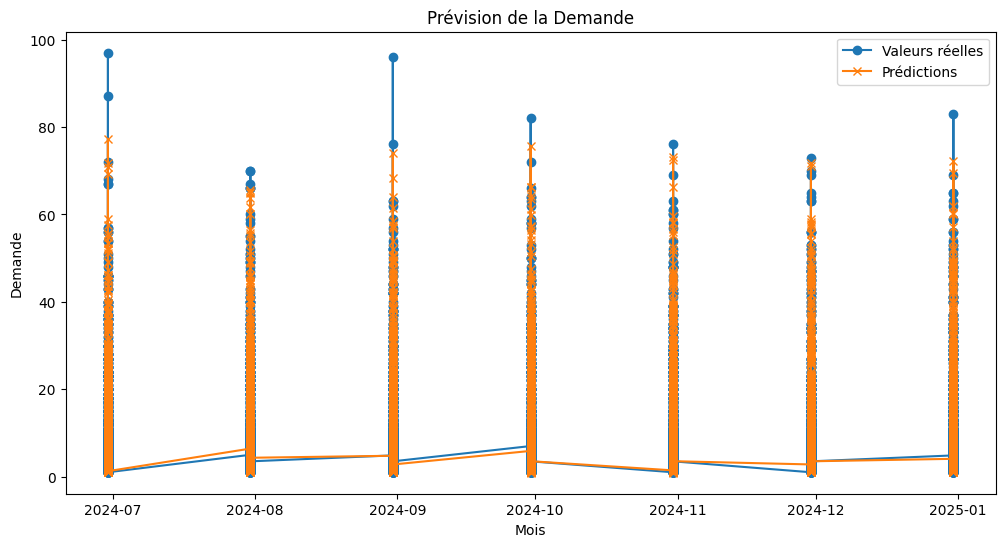

In [422]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
import numpy as np

# Vérifier si le jeu de test est vide
if X_test.shape[0] == 0 or y_test.shape[0] == 0:
	print("Aucune donnée dans l'ensemble de test. Impossible d'évaluer le modèle ou d'afficher les prédictions.")
else:
	# Faire des prédictions sur l'ensemble de test
	y_pred = model.predict(X_test)

	# Évaluer les performances
	mae = mean_absolute_error(y_test, y_pred)
	rmse = np.sqrt(mean_squared_error(y_test, y_pred))
	mape = mean_absolute_percentage_error(y_test, y_pred)

	print(f"MAE : {mae:.2f}")
	print(f"RMSE : {rmse:.2f}")
	print(f"MAPE : {mape:.2f}")

	# Visualiser les résultats
	plt.figure(figsize=(12, 6))
	plt.plot(test['Mois'], y_test, label='Valeurs réelles', marker='o')
	plt.plot(test['Mois'], y_pred, label='Prédictions', marker='x')
	plt.xlabel('Mois')
	plt.ylabel('Demande')
	plt.title('Prévision de la Demande')
	plt.legend()
	plt.show()

C:\Users\Franck\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning:

Glyph 137 (\x89) missing from font(s) DejaVu Sans.

C:\Users\Franck\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning:

Glyph 128 (\x80) missing from font(s) DejaVu Sans.

C:\Users\Franck\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning:

Glyph 153 (\x99) missing from font(s) DejaVu Sans.



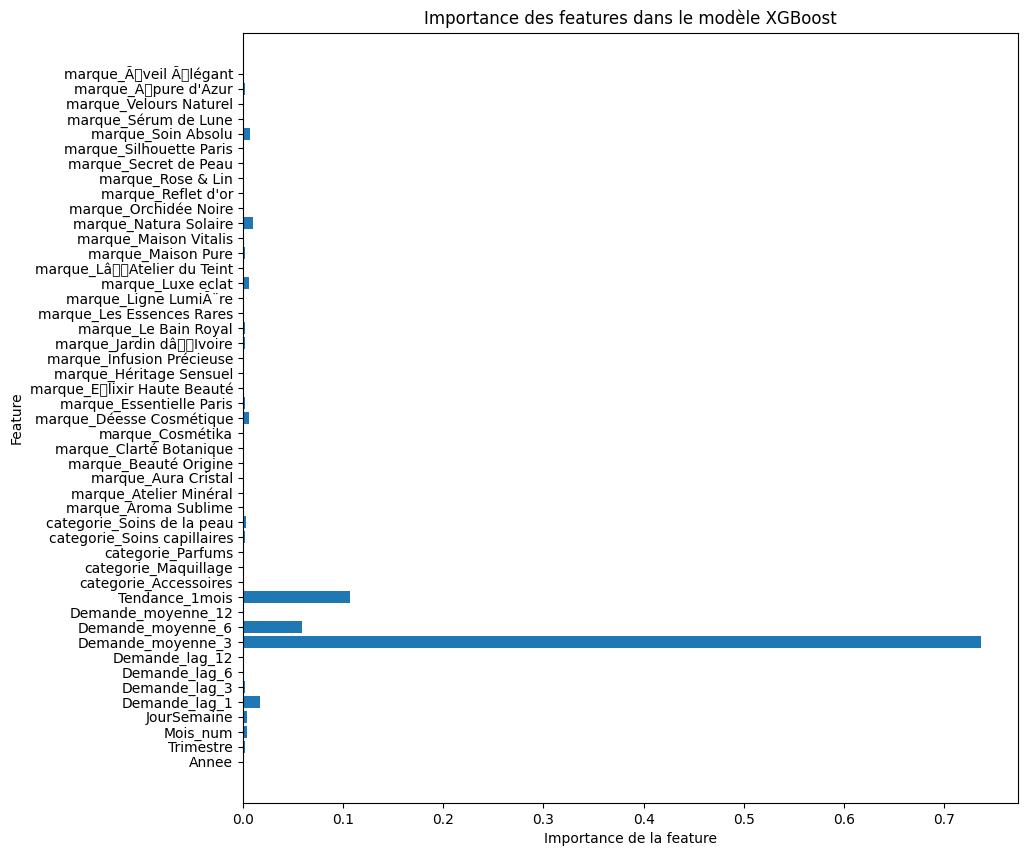

In [423]:
# Exemple d'analyse de l'importance des features (avec XGBoost)
plt.figure(figsize=(10, 10))
plt.barh(X_train.columns, model.feature_importances_)
plt.xlabel('Importance de la feature')
plt.ylabel('Feature')
plt.title('Importance des features dans le modèle XGBoost')
plt.show()


# Estimation du délai fournisseur

1. choix et préparation des datasets pertinents

In [424]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Datasets
achats = dfs_cleaned['achats']
fournisseurs = dfs_cleaned['fournisseurs']
produits = dfs_cleaned['produits']

# 2. Fusion des datasets
df = achats.merge(fournisseurs, on='id_fournisseur', how='left')
df = df.merge(produits, on='id_produit', how='left')

2. Feature Engineering

In [425]:
df['date_achat'] = pd.to_datetime(df['date_achat'], errors='coerce')
df['annee'] = df['date_achat'].dt.year
df['mois'] = df['date_achat'].dt.month
df['jour_semaine'] = df['date_achat'].dt.dayofweek  # 0=Lundi

# Suppression des colonnes inutiles et traitement des valeurs manquantes
df = df.dropna(subset=['delai_livraison_jours'])

3.  Séparation entraînement / test

In [426]:
# Variables explicatives
features = ['annee', 'mois', 'jour_semaine', 'nom_fournisseur', 'ville', 'pays', 'categorie', 'marque', 'quantite']
target = 'delai_livraison_jours'


# Séparation X / y
X = df[features]
y = df[target]

4. préparation et entraînement du modèle

In [427]:
# Préparation pipeline de traitement
cat_features = ['nom_fournisseur', 'ville', 'pays', 'categorie', 'marque']
num_features = ['annee', 'mois', 'jour_semaine', 'quantite']

preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)
], remainder='passthrough')

model = Pipeline([
    ('prep', preprocessor),
    ('rf', RandomForestRegressor(n_estimators=100, random_state=42))
])

In [428]:
# Split train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)




In [429]:
# Entraînement
model.fit(X_train, y_train)

# Prédiction & évaluation
y_pred = model.predict(X_test)

print("Précision du modèle :")
print("MSE :", mean_squared_error(y_test, y_pred))
print("RMSE :", np.sqrt(mean_squared_error(y_test, y_pred)))
print("MAE :", mean_absolute_error(y_test, y_pred))
print("R² Score :", r2_score(y_test, y_pred))

Précision du modèle :
MSE : 15.363666857267573
RMSE : 3.9196513693525823
MAE : 3.3249118095238095
R² Score : -0.0890162583018832


5. Visualisation

In [430]:
import plotly.graph_objects as go
import numpy as np
from sklearn.model_selection import learning_curve

# Courbe d’apprentissage
def plot_learning_curve(model, X, y, title="Courbe d'apprentissage"):
    train_sizes, train_scores, test_scores = learning_curve(
        model, X, y, cv=5, scoring='neg_mean_absolute_error',
        train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=-1
    )
    train_scores_mean = -train_scores.mean(axis=1)
    test_scores_mean = -test_scores.mean(axis=1)

    fig = go.Figure()
    fig.add_trace(go.Scatter(x=train_sizes, y=train_scores_mean, mode='lines+markers', name='Erreur d\'entraînement'))
    fig.add_trace(go.Scatter(x=train_sizes, y=test_scores_mean, mode='lines+markers', name='Erreur de validation'))
    fig.update_layout(title=title,
                      xaxis_title='Taille de l\'échantillon d\'entraînement',
                      yaxis_title='Erreur absolue moyenne (MAE)',
                      template='plotly_white')
    fig.show()

plot_learning_curve(model, X, y)


In [431]:
# Récupération des noms après encodage
ohe = model.named_steps['prep'].named_transformers_['cat']
cat_feature_names = ohe.get_feature_names_out(cat_features)
all_features = list(cat_feature_names) + num_features

# Importance des variables
importances = model.named_steps['rf'].feature_importances_
sorted_idx = np.argsort(importances)[::-1]

fig = go.Figure(go.Bar(
    x=importances[sorted_idx],
    y=[all_features[i] for i in sorted_idx],
    orientation='h',
    marker_color='indianred'
))
fig.update_layout(title="Importance des variables",
                  xaxis_title="Importance",
                  yaxis_title="Variables",
                  template='plotly_white')
fig.show()


In [432]:
#prediction vs réel
fig = go.Figure()
fig.add_trace(go.Scatter(x=y_test, y=y_pred,
                         mode='markers',
                         marker=dict(color='blue', opacity=0.5),
                         name='Prédictions'))
fig.add_trace(go.Scatter(x=y_test, y=y_test, mode='lines', name='Idéal', line=dict(color='red')))
fig.update_layout(title='Prédictions vs Réel',
                  xaxis_title='Délai réel',
                  yaxis_title='Délai prédit',
                  template='plotly_white')
fig.show()


In [433]:
#distribution des délais (réel vs prédit)
fig = go.Figure()
fig.add_trace(go.Histogram(x=y_test, nbinsx=20, name='Réel', opacity=0.6))
fig.add_trace(go.Histogram(x=y_pred, nbinsx=20, name='Prédit', opacity=0.6))
fig.update_layout(barmode='overlay',
                  title='Distribution des délais de livraison',
                  xaxis_title='Délai (jours)',
                  yaxis_title='Fréquence',
                  template='plotly_white')
fig.show()


# Analyse  de  probabilité  de  retour

1. selection et fusion des datasets pertinent

In [434]:
expeditions = dfs_cleaned['expeditions']
commandes = dfs_cleaned['commandes']
fournisseurs = dfs_cleaned['fournisseurs']
produits = dfs_cleaned['produits']
retours = dfs_cleaned['retours']

# Création de la variable cible : retour ou non
retours["retour"] = 1
commandes_retour = commandes.merge(retours[['id_commande', 'id_produit', 'retour']],
                                   on=['id_commande', 'id_produit'], how='left')
commandes_retour["retour"] = commandes_retour["retour"].fillna(0)


In [435]:
# Fusion avec expéditions
df = commandes_retour.merge(expeditions, on=['id_commande', 'id_produit'], how='left')

# Fusion avec produits
df = df.merge(produits, on='id_produit', how='left')

# Extraction de la saison à partir de la date de commande
df['date_commande'] = pd.to_datetime(df['date_commande'])
df['mois'] = df['date_commande'].dt.month
df['saison'] = df['mois'].apply(lambda x: (
    'hiver' if x in [12,1,2] else
    'printemps' if x in [3,4,5] else
    'été' if x in [6,7,8] else
    'automne'))



In [436]:
# Ajout du délai réel de livraison
df['date_expedition'] = pd.to_datetime(df['date_expedition'])
df['date_livraison'] = pd.to_datetime(df['date_livraison_x'])
df['delai_reel'] = (df['date_livraison'] - df['date_expedition']).dt.days

# Nettoyage/remplissage
df['transporteur'] = df['transporteur'].fillna('inconnu')
df['delai_reel'] = df['delai_reel'].fillna(df['delai_reel'].median())

def impute_missing_values(df):
    for column in df.columns:
        if df[column].dtype == 'object' or df[column].dtype.name == 'category':  # Catégorielles
            mode_value = df[column].mode()[0]
            df[column].fillna(mode_value, inplace=True)
        elif df[column].dtype in ['int64', 'float64']:  # Numériques
            if df[column].skew() > 1:  # Si la distribution est asymétrique
                median_value = df[column].median()
                df[column].fillna(median_value, inplace=True)
            else:  # Si la distribution est symétrique
                mean_value = df[column].mean()
                df[column].fillna(mean_value, inplace=True)
    return df
# Imputation des valeurs manquantes
df = impute_missing_values(df)

df.head(5)

C:\Users\Franck\AppData\Local\Temp\ipykernel_9060\3763686867.py:14: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



C:\Users\Franck\AppData\Local\Temp\ipykernel_9060\3763686867.py:18: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplac

,id_commande,date_commande,id_produit,quantite_x,entrepot_x,statut,date_livraison_x,delai_traitement,prix_total_ligne,retour,...,cout_transport,delai_livraison,categorie,marque,prix,stock_minimum,mois,saison,date_livraison,delai_reel
0,O000001,2024-03-09,P00413,2,Marseille,Livré,2024-09-15,190.000000,302.68,0.0,...,11.62,6,Accessoires,Essentielle Paris,151.34,50,3.000000,printemps,2024-09-15,6.0
1,O000002,2024-09-11,P00778,15,Lyon,Expédié,2024-11-23,73.000000,6512.10,0.0,...,13.61,7,Accessoires,Silhouette Paris,434.14,91,9.000000,automne,2024-11-23,32.0
2,O000004,2024-03-11,P00535,8,Lyon,Livré,2024-11-09,243.000000,2292.56,0.0,...,19.32,3,Maquillage,Soin Absolu,286.57,66,3.000000,printemps,2024-11-09,151.0
3,O000006,NaT,P00898,3,Paris,Livré,2024-01-28,47.735233,270.78,0.0,...,14.79,2,Soins de la peau,Velours Naturel,90.26,56,6.476373,automne,2024-01-28,32.0
4,O000007,NaT,P00445,1,Lyon,Livré,2024-02-21,47.735233,436.94,0.0,...,13.56,3,Accessoires,Elixir Haute Beauté,436.94,21,6.476373,automne,2024-02-21,32.0


2. Préparation des features

In [437]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Sélection des features pertinentes
features = ['categorie', 'marque', 'transporteur', 'quantite_x', 'prix', 'delai_reel', 'saison']
X = df[features]
y = df['retour']

# Encodage des variables catégorielles
cat_cols = ['categorie', 'marque', 'transporteur', 'saison']
num_cols = ['quantite', 'prix', 'delai_reel']

preprocessor = ColumnTransformer(transformers=[
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
], remainder='passthrough')

# Pipeline de classification
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

# Entraînement
pipeline.fit(X_train, y_train)

# Prédiction
y_pred = pipeline.predict(X_test)


3. Visualisation et évaluation

In [438]:
import plotly.express as px
import plotly.graph_objects as go
from sklearn.metrics import confusion_matrix

# Répartition des retours
fig1 = px.pie(df, names='retour', title='Répartition des retours (1 = retour, 0 = non-retour)')
fig1.show()

# Taux de retour par transporteur
fig2 = px.bar(df.groupby('transporteur')['retour'].mean().reset_index(),
              x='transporteur', y='retour', title='Taux de retour par transporteur')
fig2.show()

# Taux de retour par saison
fig3 = px.bar(df.groupby('saison')['retour'].mean().reset_index(),
              x='saison', y='retour', title='Taux de retour par saison')
fig3.show()


print("Rapport de classification :")
print(classification_report(y_test, y_pred))
print("Matrice de confusion :")
print(confusion_matrix(y_test, y_pred))


Rapport de classification :
              precision    recall  f1-score   support

         0.0       0.97      0.98      0.98      7895
         1.0       0.73      0.59      0.65       597

    accuracy                           0.96      8492
   macro avg       0.85      0.79      0.82      8492
weighted avg       0.95      0.96      0.95      8492

Matrice de confusion :
[[7761  134]
 [ 242  355]]
